In [2]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
#reading freesurfer results
out_dir = Path("/output")
fig_dir = out_dir / "figs"
fsdata_file = out_dir / 'freesurfer_out_preped.csv'
tab_data = pd.read_csv(fsdata_file, sep=',', header=0, index_col=0);
# distribution of large brain parts ratio
def lr_ratio(data, items_basic, items_single, items_lr):
    item_left   = [ "Left_"+x  for x in items_lr];
    item_right  = [ "Right_"+x for x in items_lr];
    items_all = items_single + item_left + item_right + items_lr;
    tmp_data = data[items_basic+items_single+item_left+item_right];
    for x in items_lr:
        tmp_data[x]  = tmp_data["Left_"+x] + tmp_data["Right_"+x]
    #for x in items_all:
    #    tmp_data[x+"_r"] = tmp_data[x]/tmp_data["eTIV"]  
    return tmp_data, items_basic+items_all
tab_data=tab_data.drop(index='sub_0064');
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
tab_data=tab_data.drop(columns=drop_col_list);

201204-03:22:50,56 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


In [3]:
def rm_age_sex(data, var_list):
    from sklearn import linear_model
    import numpy as np
    dat = data.copy()
    nc_data = dat[dat["is_NC"] == 1]
    x_nc = np.array([np.ones(nc_data.shape[0]), np.array((nc_data["is_Male"])), np.array((nc_data["age"]))]).T; 
    x_all= np.array([np.ones(dat.shape[0]), np.array((dat["is_Male"])), np.array((dat["age"]))]).T;
    reg_list = []; new_col=[];
    for x in var_list:
        reg = linear_model.LinearRegression()
        y_nc= np.array(nc_data[x]);
        reg.fit(x_nc, y_nc);
        tmp_col = x+"_AgeSexRemoved"
        dat[tmp_col] = dat[x]-np.matmul(x_all[:,1:], reg.coef_[1:])
        dat[tmp_col+"_resid"] = dat[x]-reg.predict(x_all)
        dat[tmp_col+"_resid_per"] = (dat[x]-reg.predict(x_all))/dat[x]
        reg_list.append(reg); new_col.append(tmp_col);
    return dat, new_col, reg_list   
# plot distribution of brian tissues
def screen_Tukeyhsd(data, test_list):
    import statsmodels.stats.multicomp as mc
    from functools import reduce
    res_all=[]; reject_index=[];
    for i in range(len(test_list)):
        x = test_list[i];
        #print(x)
        tmp_comp = mc.MultiComparison(data[x], data['diagnosis'])
        tmp_res = tmp_comp.tukeyhsd()
        res_all.append(tmp_res.summary())
        if sum(list(tmp_res.reject))>2:
            reject_index.append(i)
            print(str(i)+"th Tukey HSD test positive -->> "+x)
            print(res_all[i])
            #print(res_all[i])
    return res_all, reject_index

In [4]:
# select the data
from sklearn import linear_model
import numpy as np
items_basic = ["diagnosis", "age", "sex", "is_PD", "is_ET","is_NC",
               "is_Male", "is_Female", "eTIV", "TotalGrayVol",];
items_single = ["CerebralWhiteMatterVol", "CortexVol", "Brain_Stem", "SubCortGrayVol", "CSF", 
                "3rd_Ventricle", "4th_Ventricle", "SupraTentorialVol", 
                "CC_Anterior", "CC_Central", "CC_Mid_Anterior", "CC_Mid_Posterior", "CC_Posterior"];
items_lr  = ["Inf_Lat_Vent", "Lateral_Ventricle", 
             "Cerebellum_Cortex", "Cerebellum_White_Matter",
             "Accumbens_area", "Amygdala", "Hippocampus", 
             "Pallidum", "Caudate", "Putamen", "Thalamus_Proper"];
all_data, items_all = lr_ratio(tab_data, items_basic, items_single, items_lr);
rm_AgeSex_list = items_all[8:];

new_data=all_data[all_data["age"]>=60];
stf_data=new_data[new_data["age"]<=69];

all_as_data, rm_as_col_list, rm_as_reg_list = rm_age_sex(all_data, rm_AgeSex_list);
stf_as_data, rm_as_col_list, rm_as_reg_list = rm_age_sex(stf_data, rm_AgeSex_list);

# Check regression residuals
resid_list = [x+"_resid_per" for x in rm_as_col_list ];
#rm_as_data[resid_list].plot.box(vert=False,figsize=(10,20))

/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


60-70: 
PD :  17
ET :  5
NC :  7
all: 
PD :  40
ET :  29
NC :  32


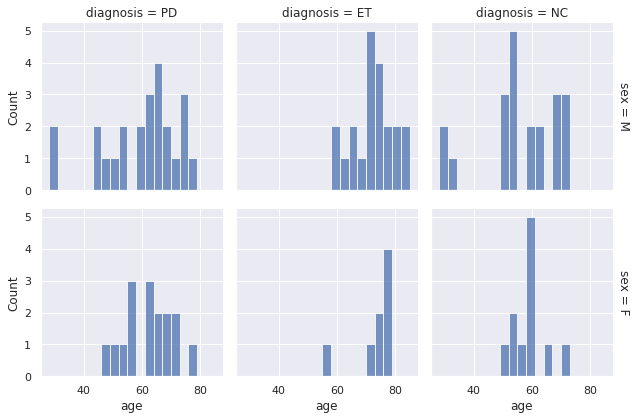

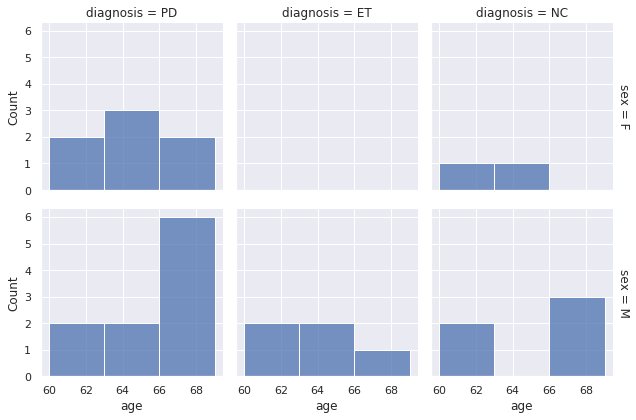

In [6]:
# age and sex distribution
import seaborn as sns
GROUPS  = ['PD','ET','NC']
print("60-70: ")
[print(x, ': ', len(stf_as_data[stf_as_data["diagnosis"]==x])) for x in GROUPS]
print("all: ")
[print(x, ': ', len(all_as_data[all_as_data["diagnosis"]==x])) for x in GROUPS]

sns.set_theme(style="darkgrid")
sns.displot(
    all_as_data, x="age", col="diagnosis", row="sex",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))
sns.displot(
    stf_as_data, x="age", col="diagnosis", row="sex",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

In [7]:
def norm_by_feature(data, item_list, norm_item):
    t_data = data.copy();
    new_items=[];
    for x in item_list:
        new_col = x+"_r";
        t_data[new_col] = t_data[x]/t_data[norm_item];
        new_items.append(new_col)
    return t_data, new_items 
norm_item = 'eTIV_AgeSexRemoved';

all_asr_data, rm_asr_items = norm_by_feature(all_as_data, rm_as_col_list[1:]+rm_AgeSex_list[:], norm_item)
stf_asr_data, rm_asr_items = norm_by_feature(stf_as_data, rm_as_col_list[1:]+rm_AgeSex_list[:], norm_item)

In [8]:
non_feature_list = ["diagnosis", "age", "sex", "is_PD", "is_ET","is_NC", "is_Male", "is_Female"];
# all_asr_data, all_as_data, all_data
x_all_data = all_asr_data;
x_stf_data = stf_asr_data;
print("Screening all data(asr):")
res_all, reject_asr_index_all = screen_Tukeyhsd(all_asr_data, all_asr_data.columns.drop(non_feature_list))
print('All data Discovered diff: ',len(reject_asr_index_all))
print('Diff features: ',all_asr_data.columns.drop(non_feature_list)[reject_asr_index_all])
print("Screening 60-70 data(asr):")
res_stf, reject_asr_index_stf = screen_Tukeyhsd(stf_asr_data, stf_asr_data.columns.drop(non_feature_list))
print('60-70 Discovered diff: ',len(reject_asr_index_stf))
print('Diff features: ',stf_asr_data.columns.drop(non_feature_list)[reject_asr_index_stf])

#raw data
print("Screening all data raw:")
res_all, reject_index_all = screen_Tukeyhsd(all_data, all_data.columns.drop(non_feature_list))
print('All data Discovered diff: ',len(reject_index_all))
print('Diff features: ',all_data.columns.drop(non_feature_list)[reject_index_all])
print("Screening 60-70 data raw:")
res_stf, reject_index_stf = screen_Tukeyhsd(stf_data, stf_data.columns.drop(non_feature_list))
print('60-70 Discovered diff: ',len(reject_index_stf))
print('Diff features: ',stf_data.columns.drop(non_feature_list)[reject_index_stf])

Screening all data(asr):
All data Discovered diff:  0
Diff features:  Index([], dtype='object')
Screening 60-70 data(asr):
60-70 Discovered diff:  0
Diff features:  Index([], dtype='object')
Screening all data raw:
All data Discovered diff:  0
Diff features:  Index([], dtype='object')
Screening 60-70 data raw:
60-70 Discovered diff:  0
Diff features:  Index([], dtype='object')


/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 vari

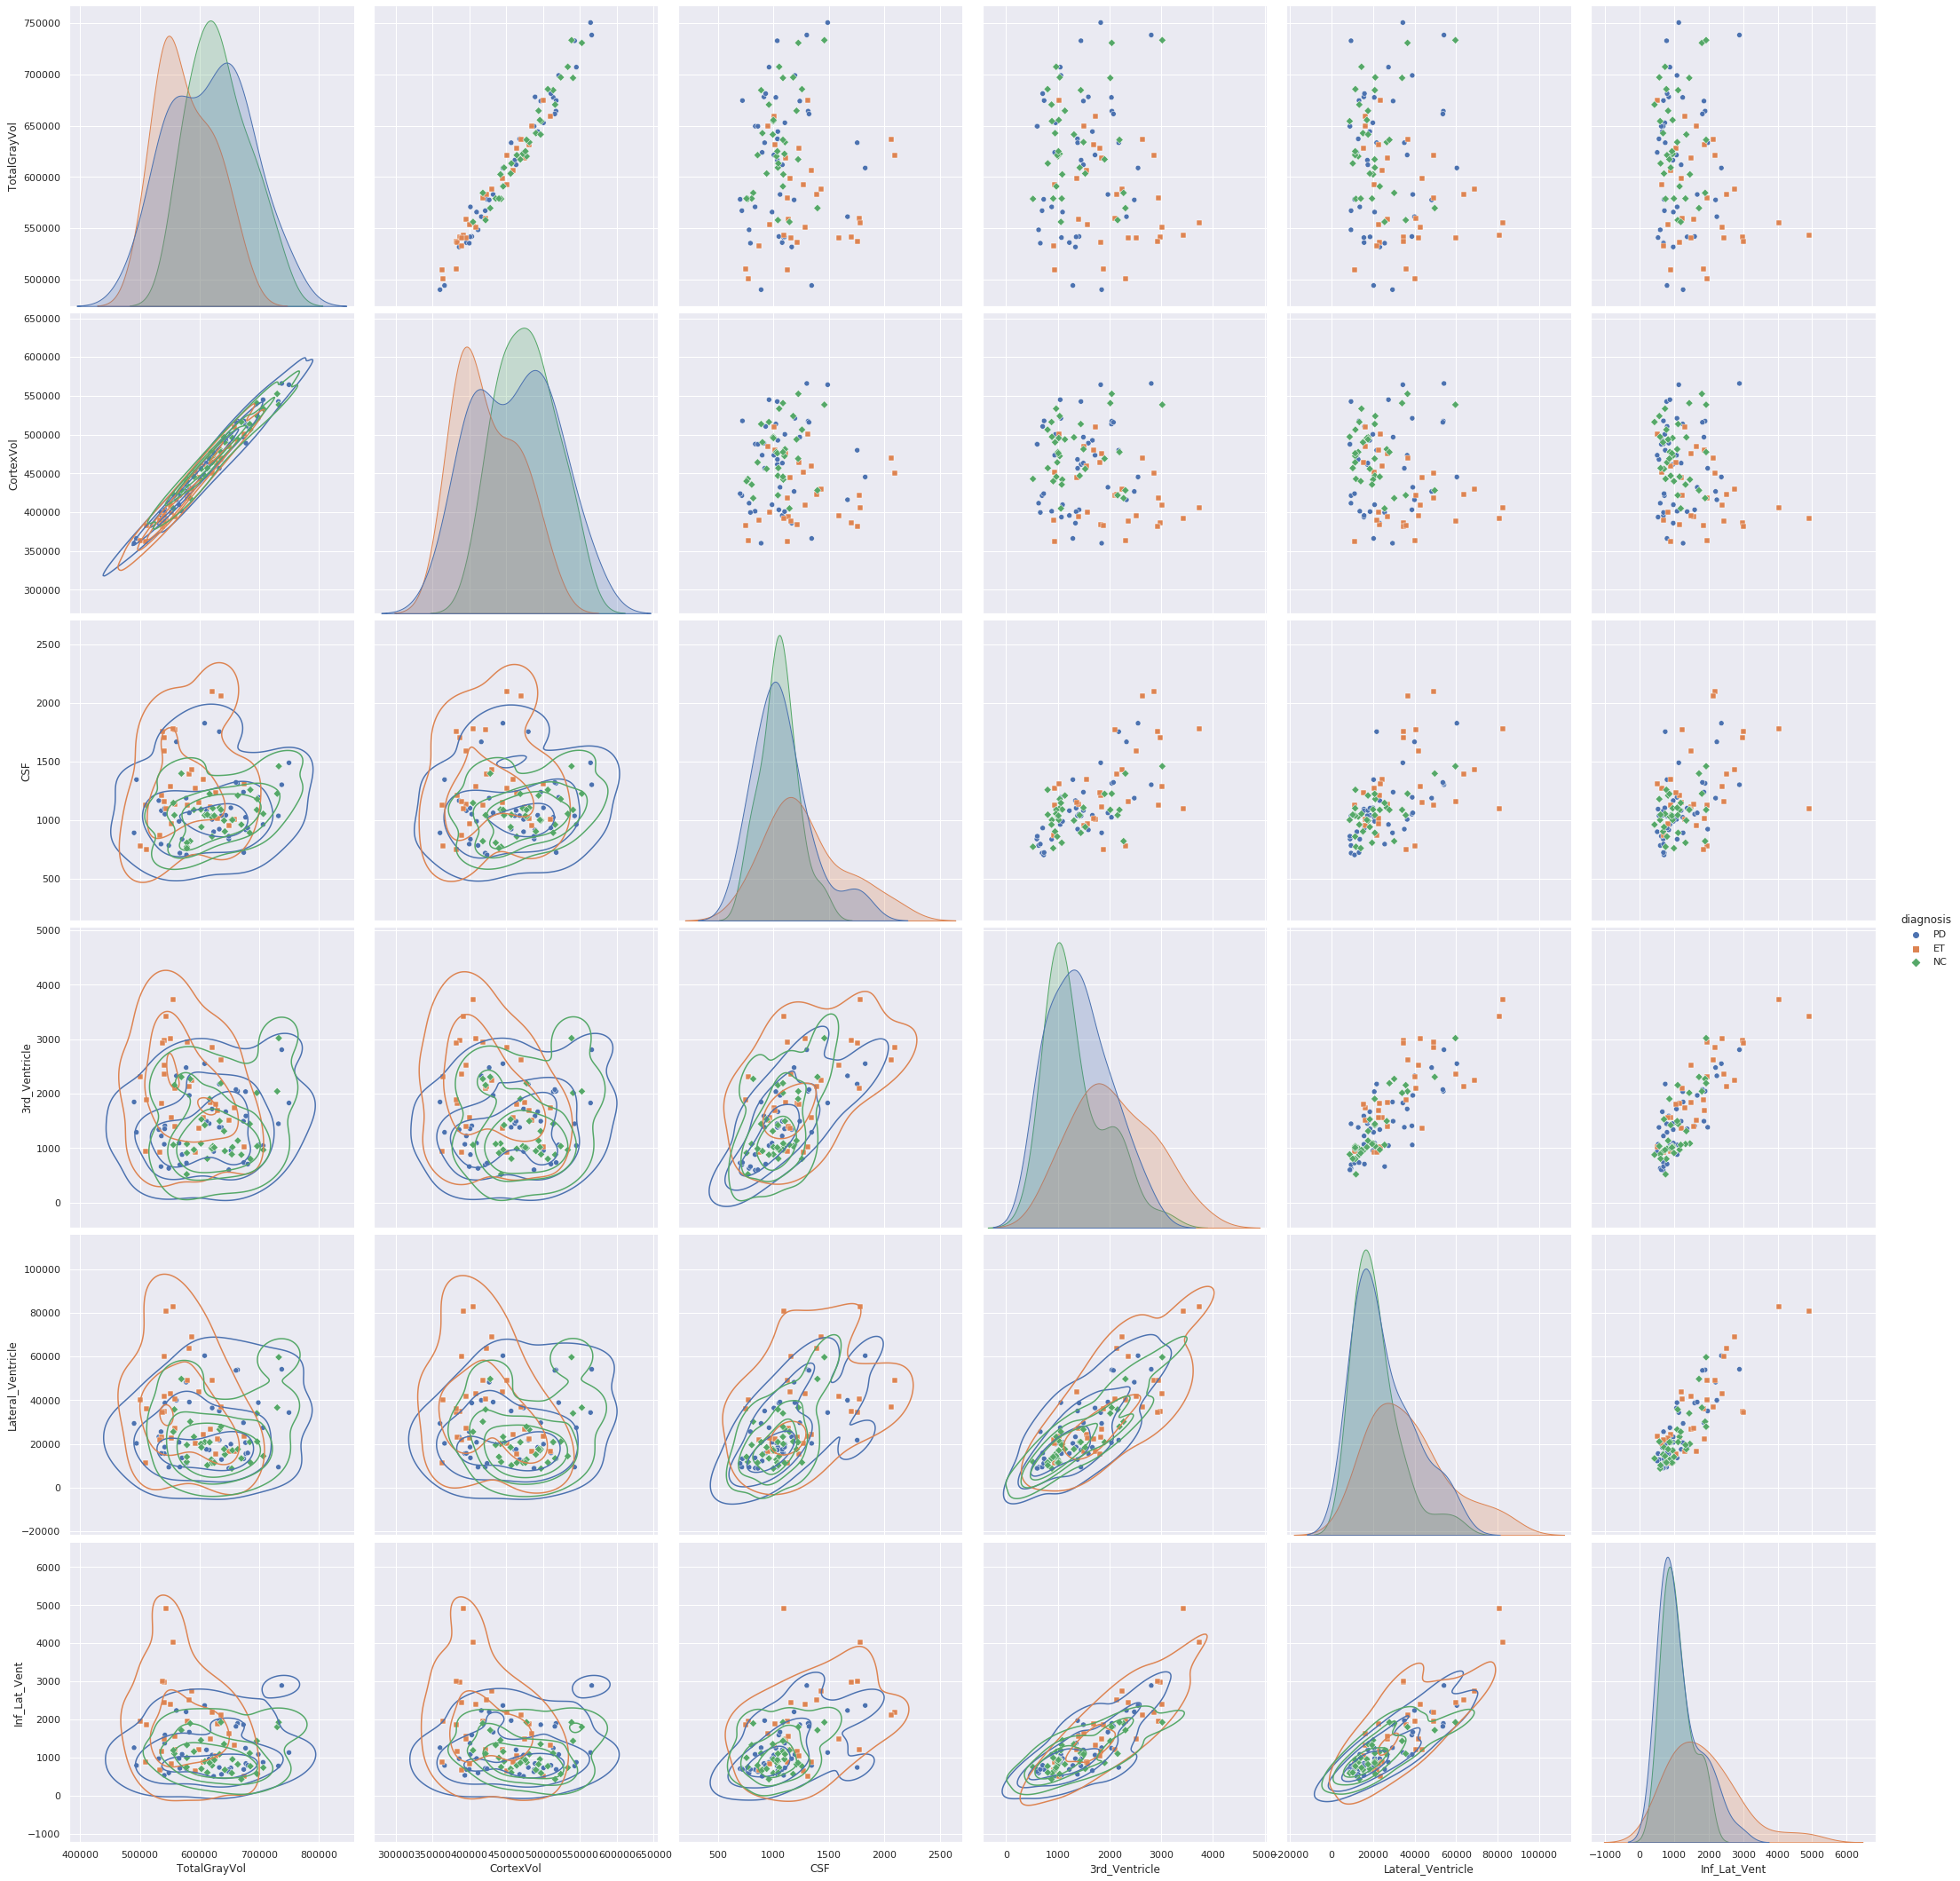

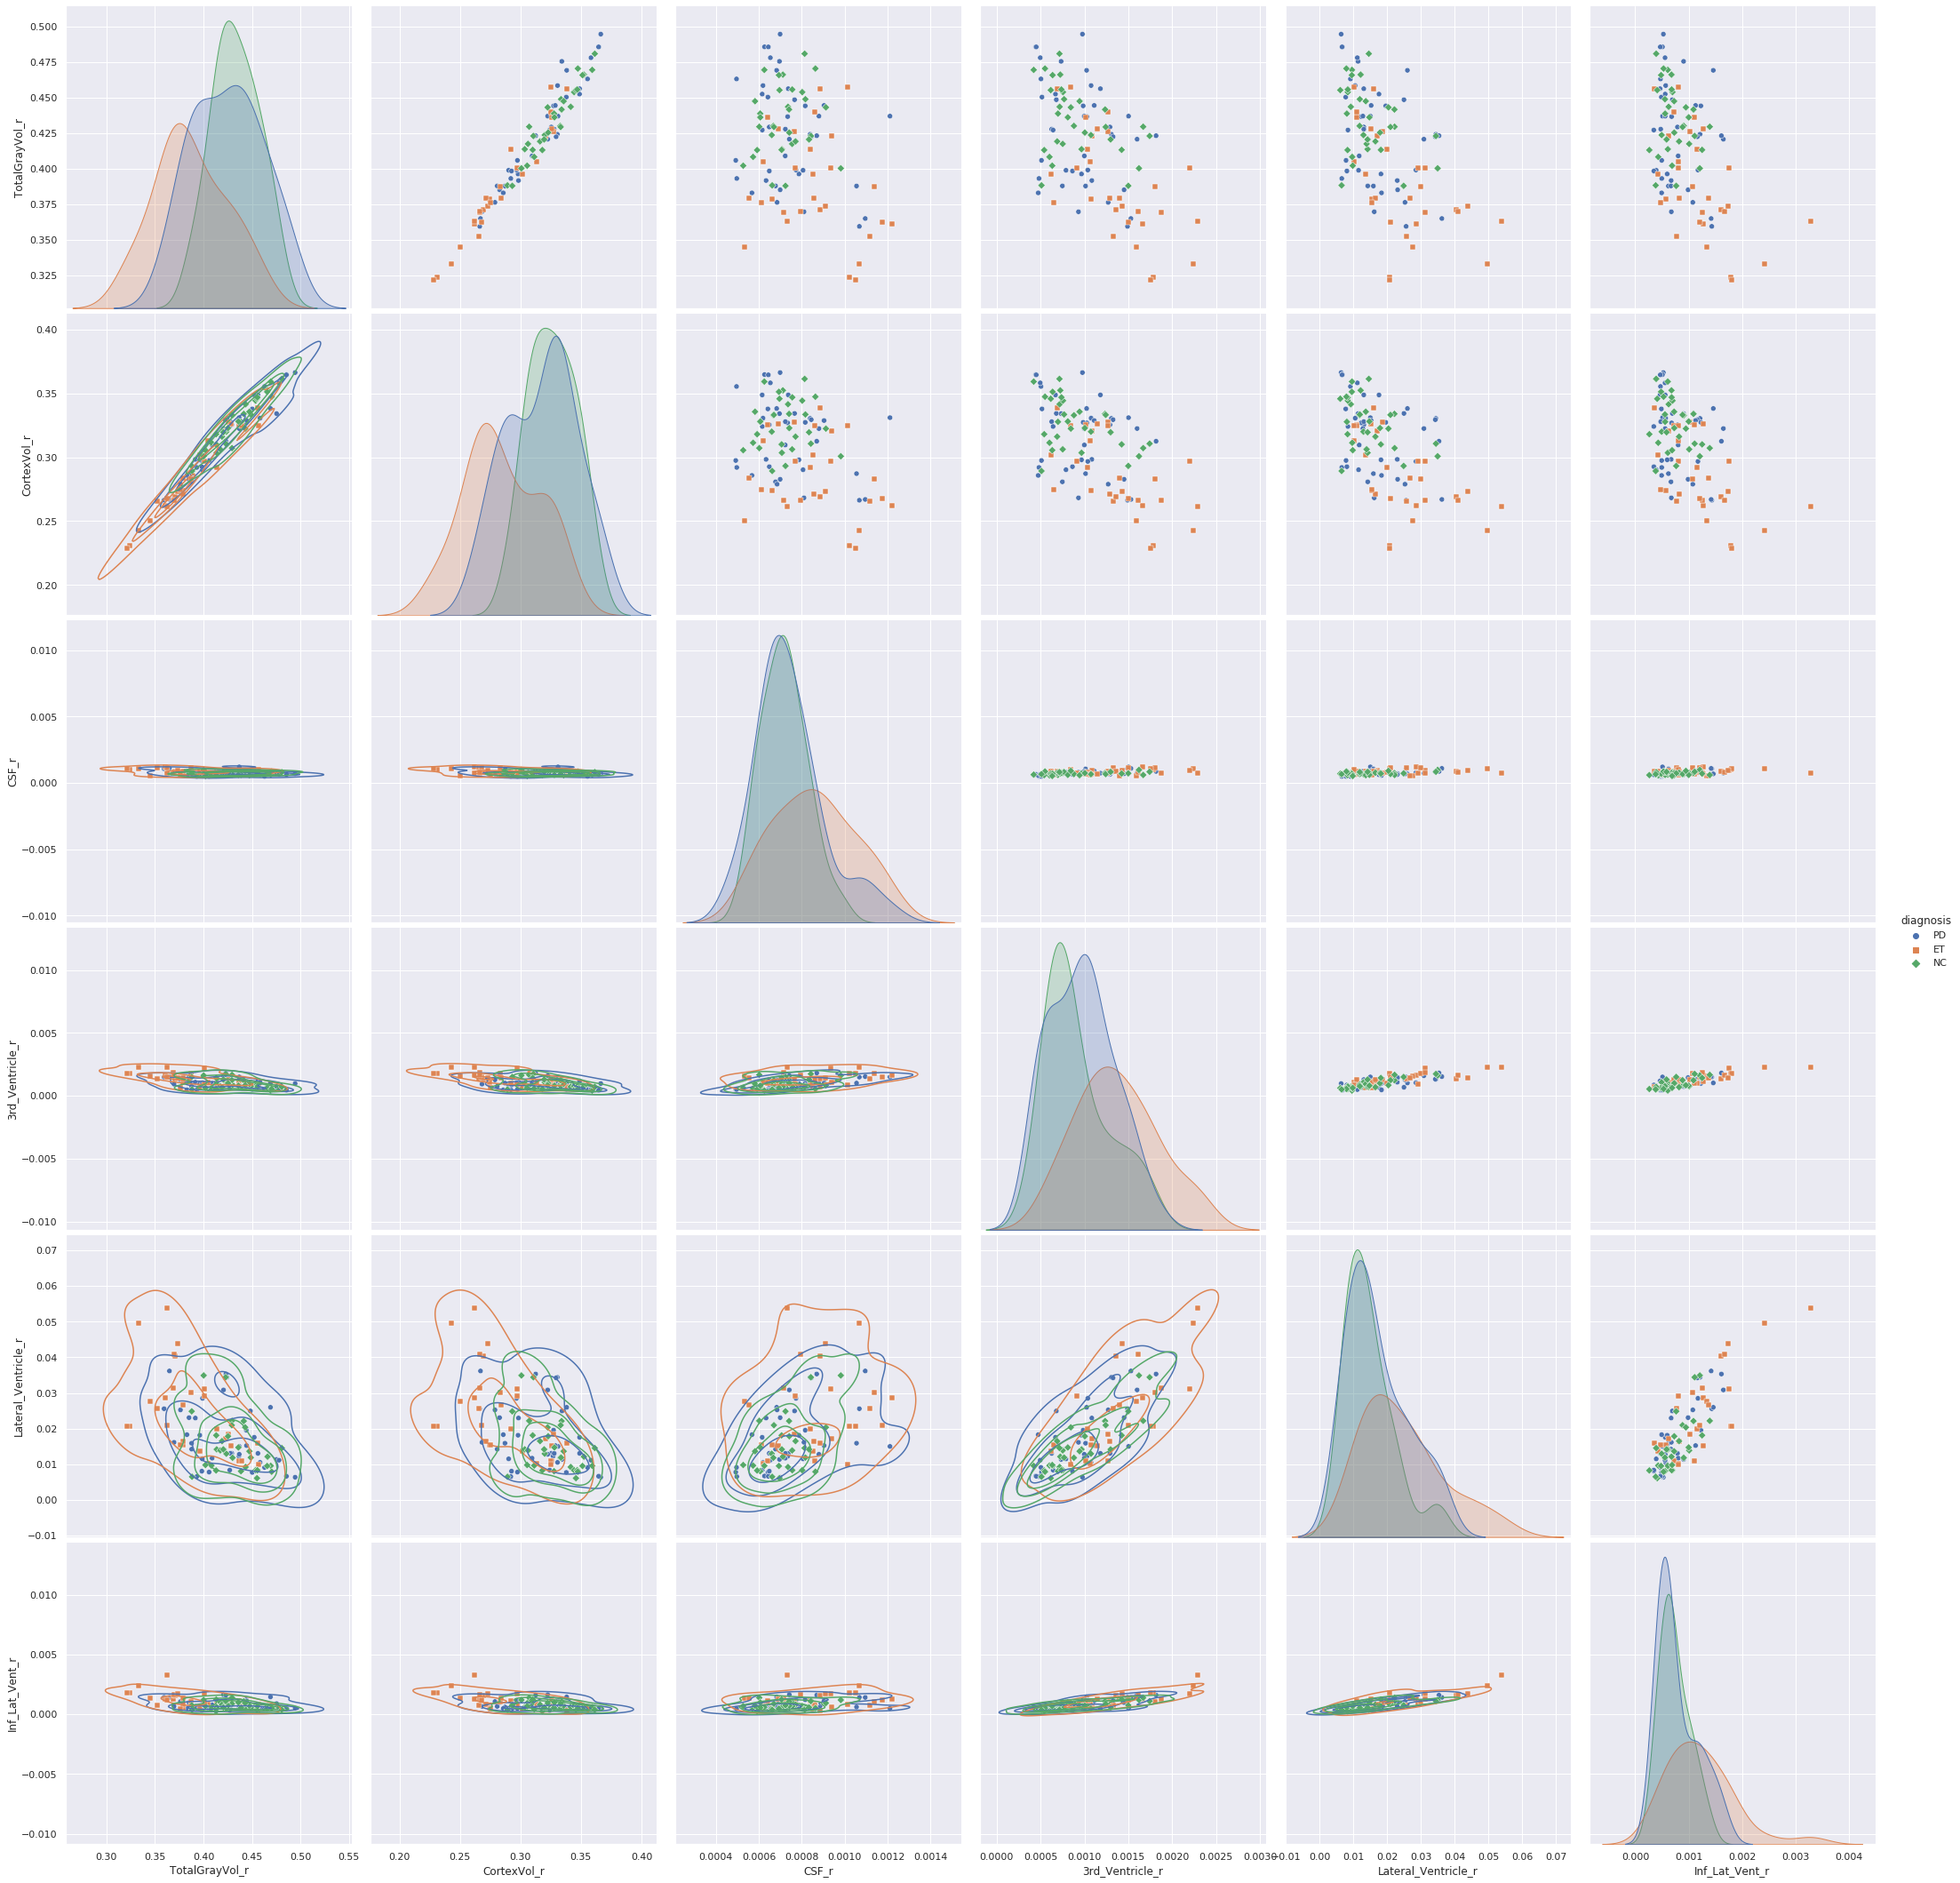

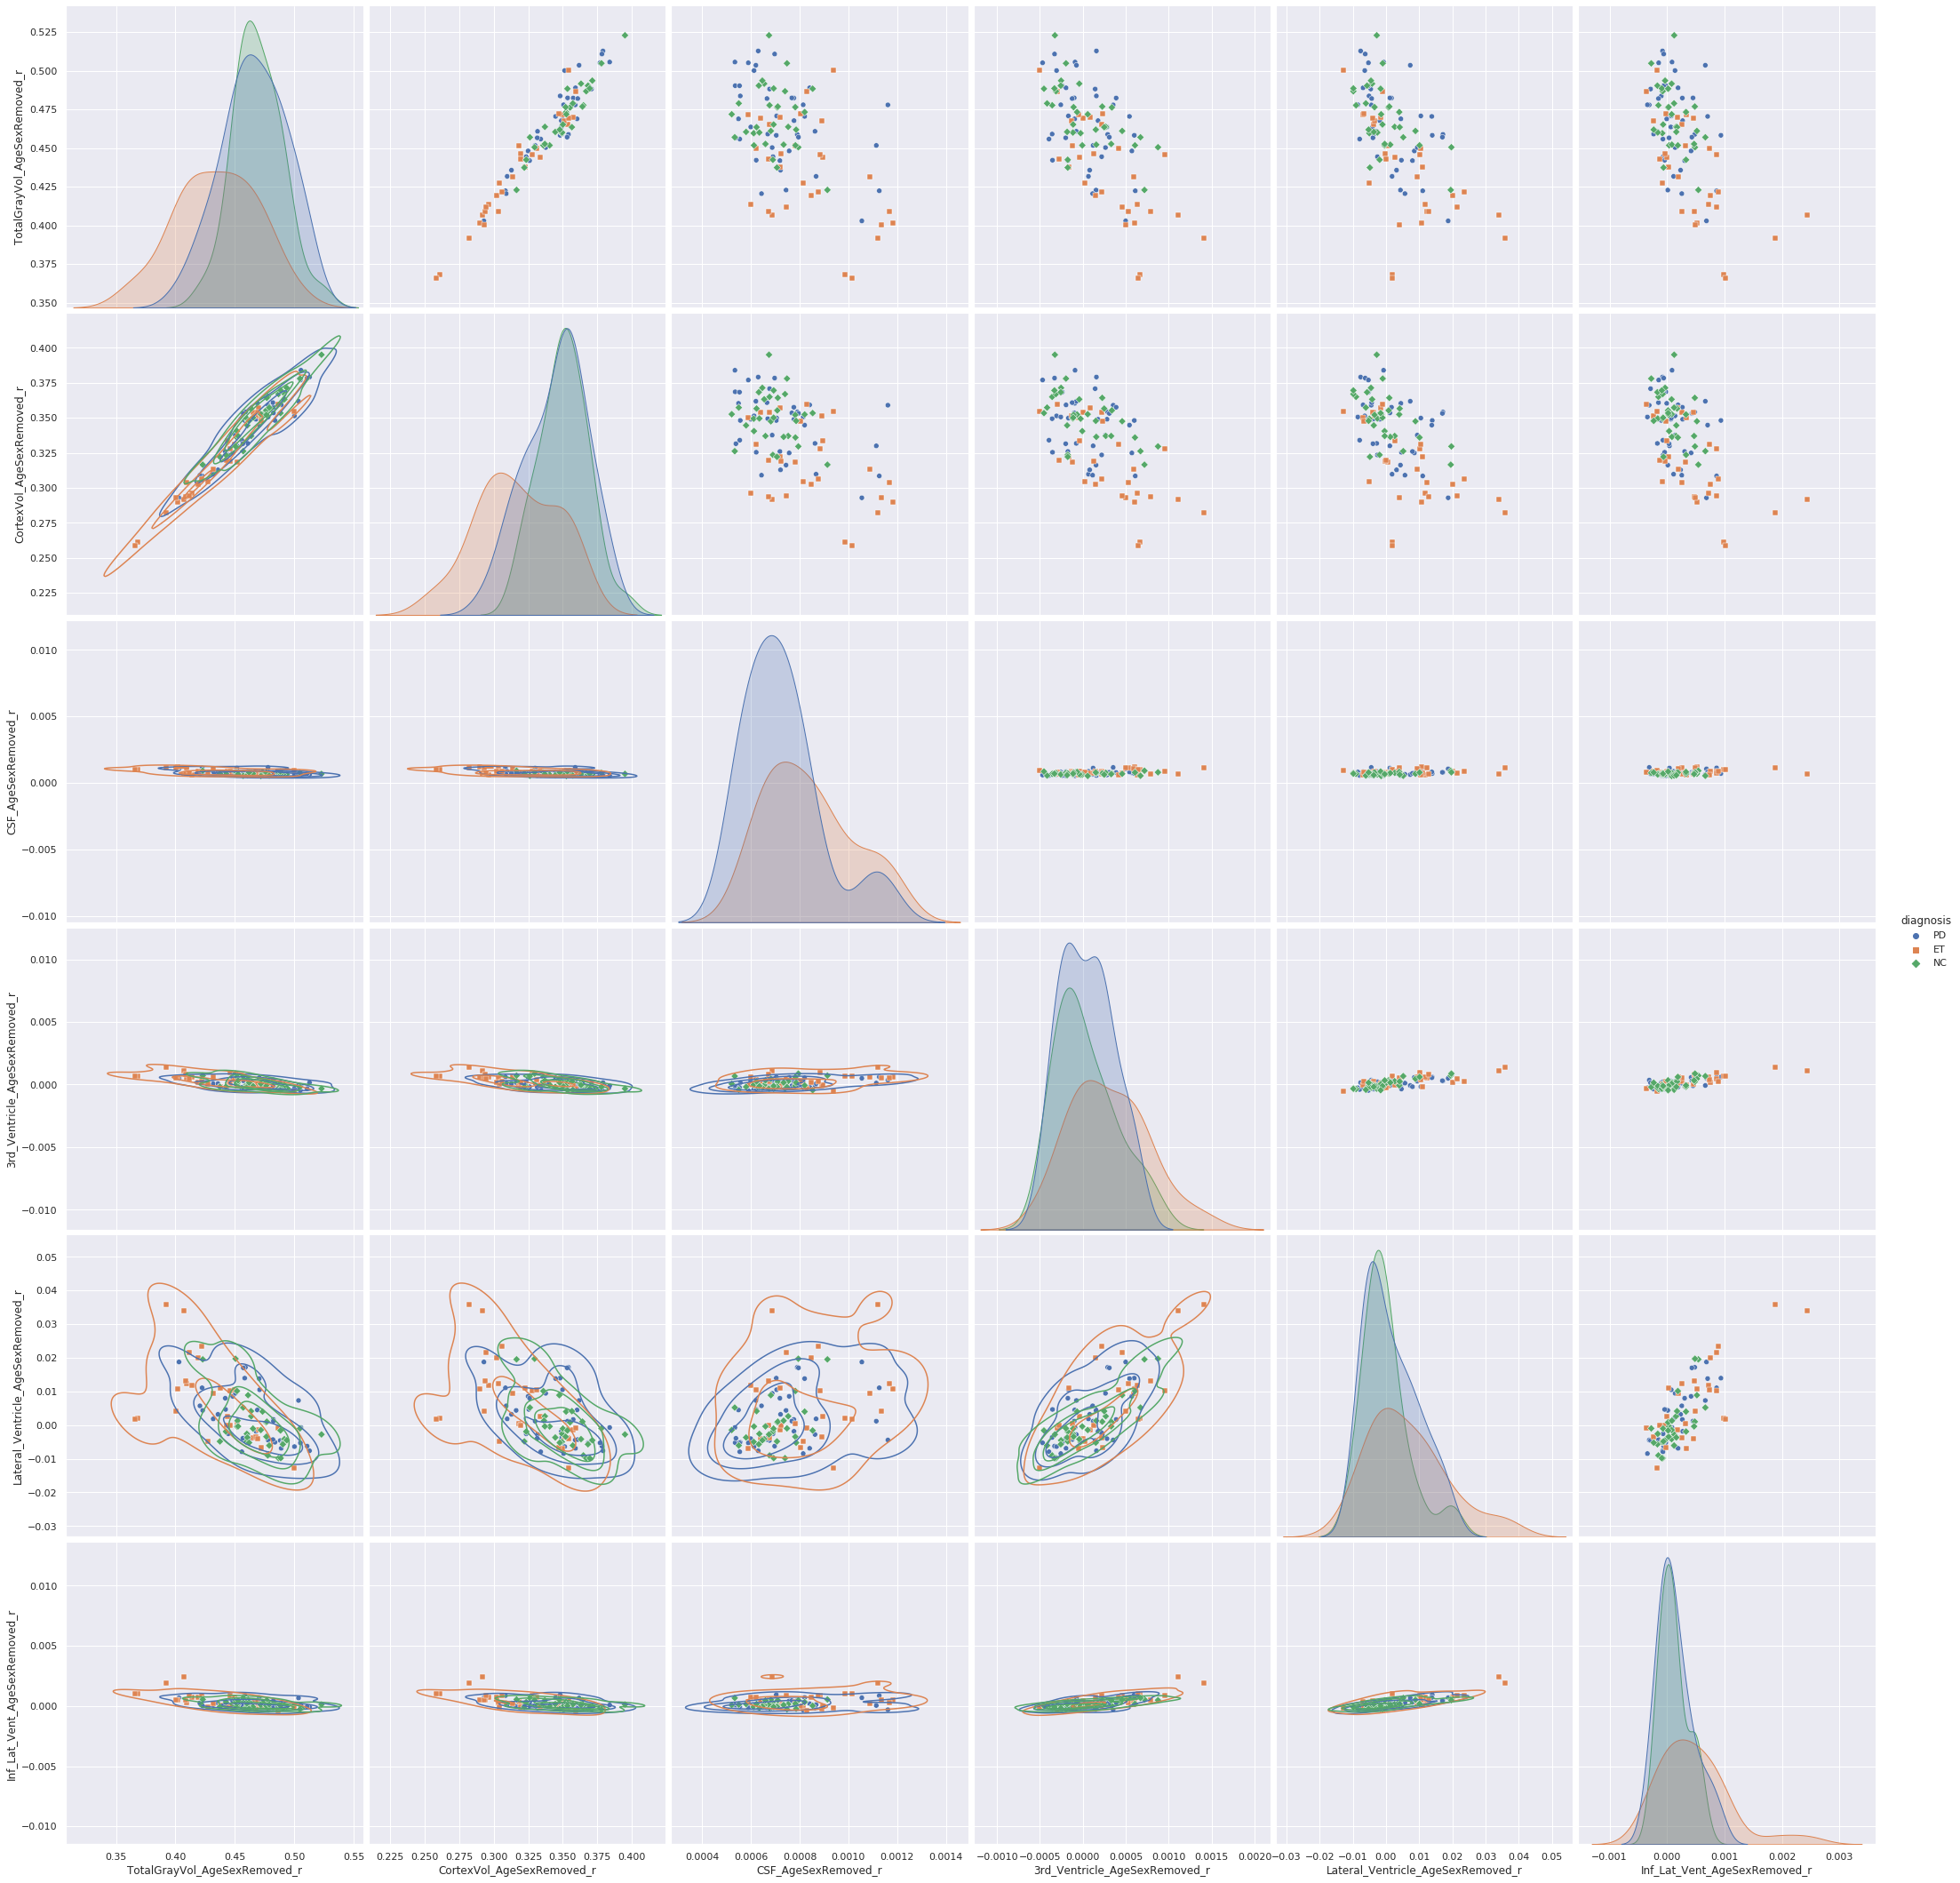

In [22]:
# all_asr_data, stf_asr_data, all_data, stf_data
region_focus = ['TotalGrayVol', 'CortexVol', 'CSF', '3rd_Ventricle', 'Lateral_Ventricle', 'Inf_Lat_Vent'];
region_r_focus = [ x+'_r'for x in region_focus];
region_asr_focus = [ x+'_AgeSexRemoved_r'for x in region_focus];

t1=sns.pairplot(all_asr_data, vars=region_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)
t1.map_lower(sns.kdeplot, levels=4, color=".2")

t2=sns.pairplot(all_asr_data, vars=region_r_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)
t2.map_lower(sns.kdeplot, levels=4, color=".2")

t3=sns.pairplot(all_asr_data, vars=region_asr_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)
t3.map_lower(sns.kdeplot, levels=4, color=".2")

/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance;

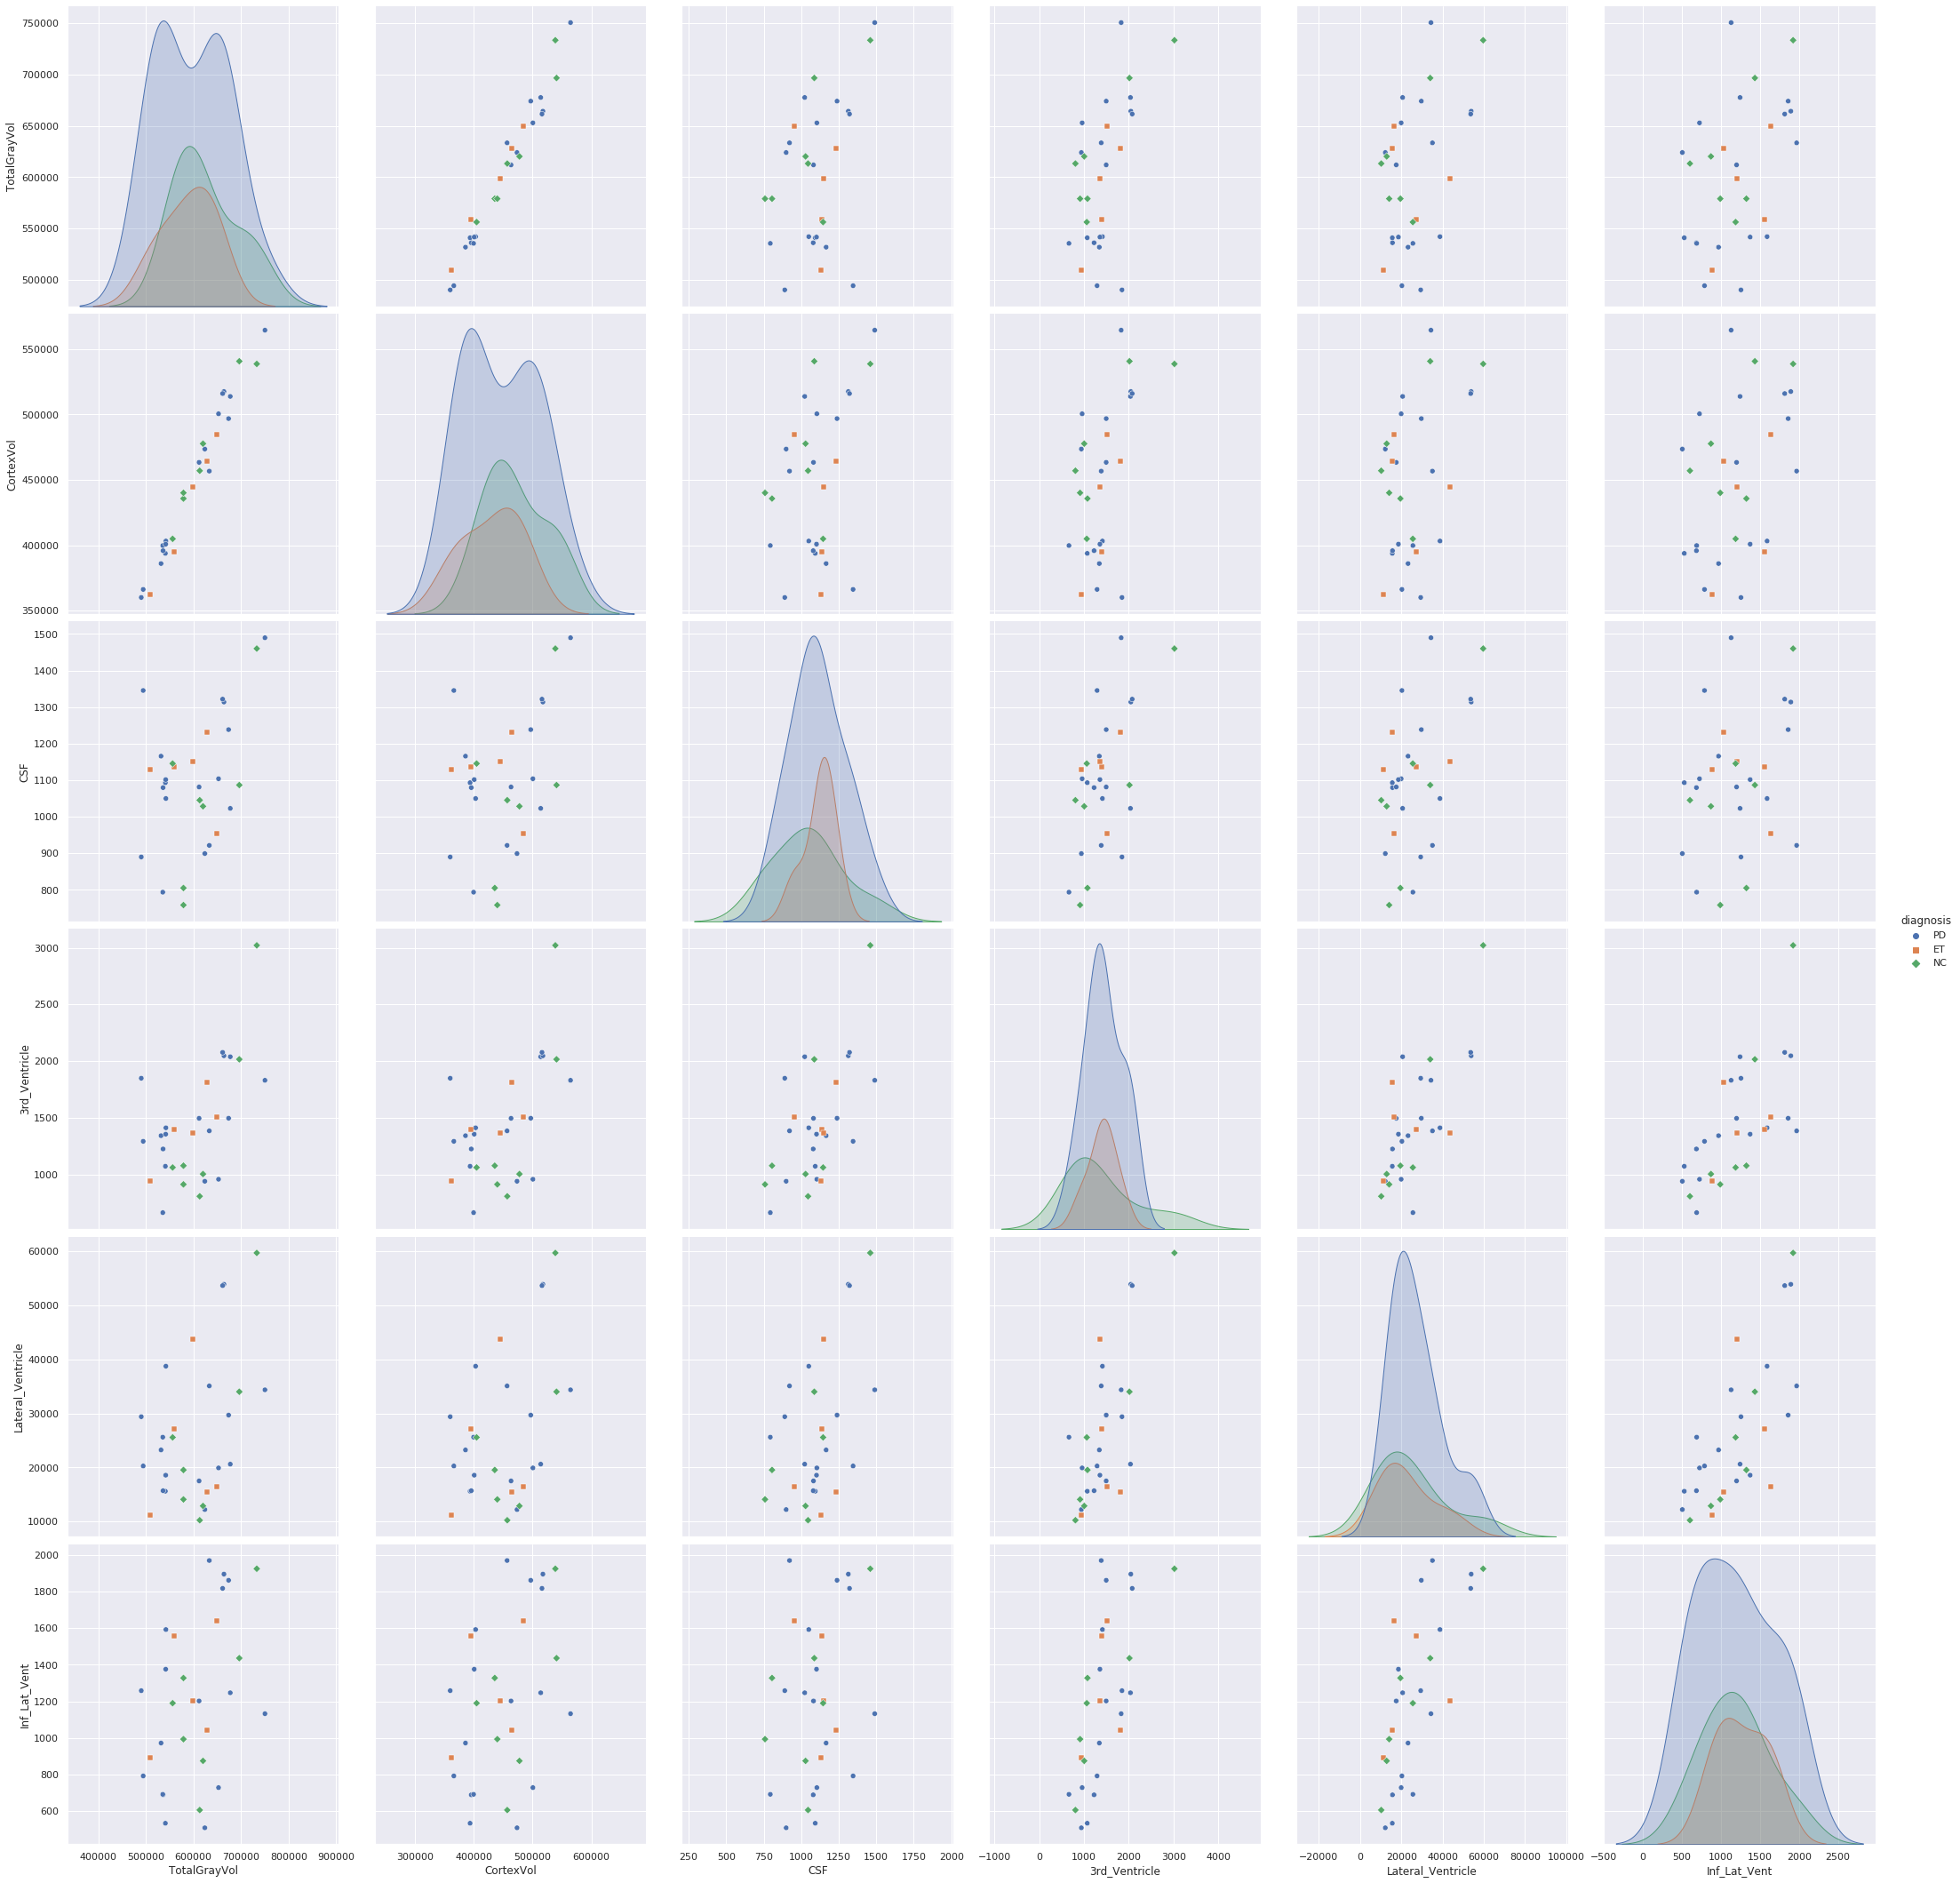

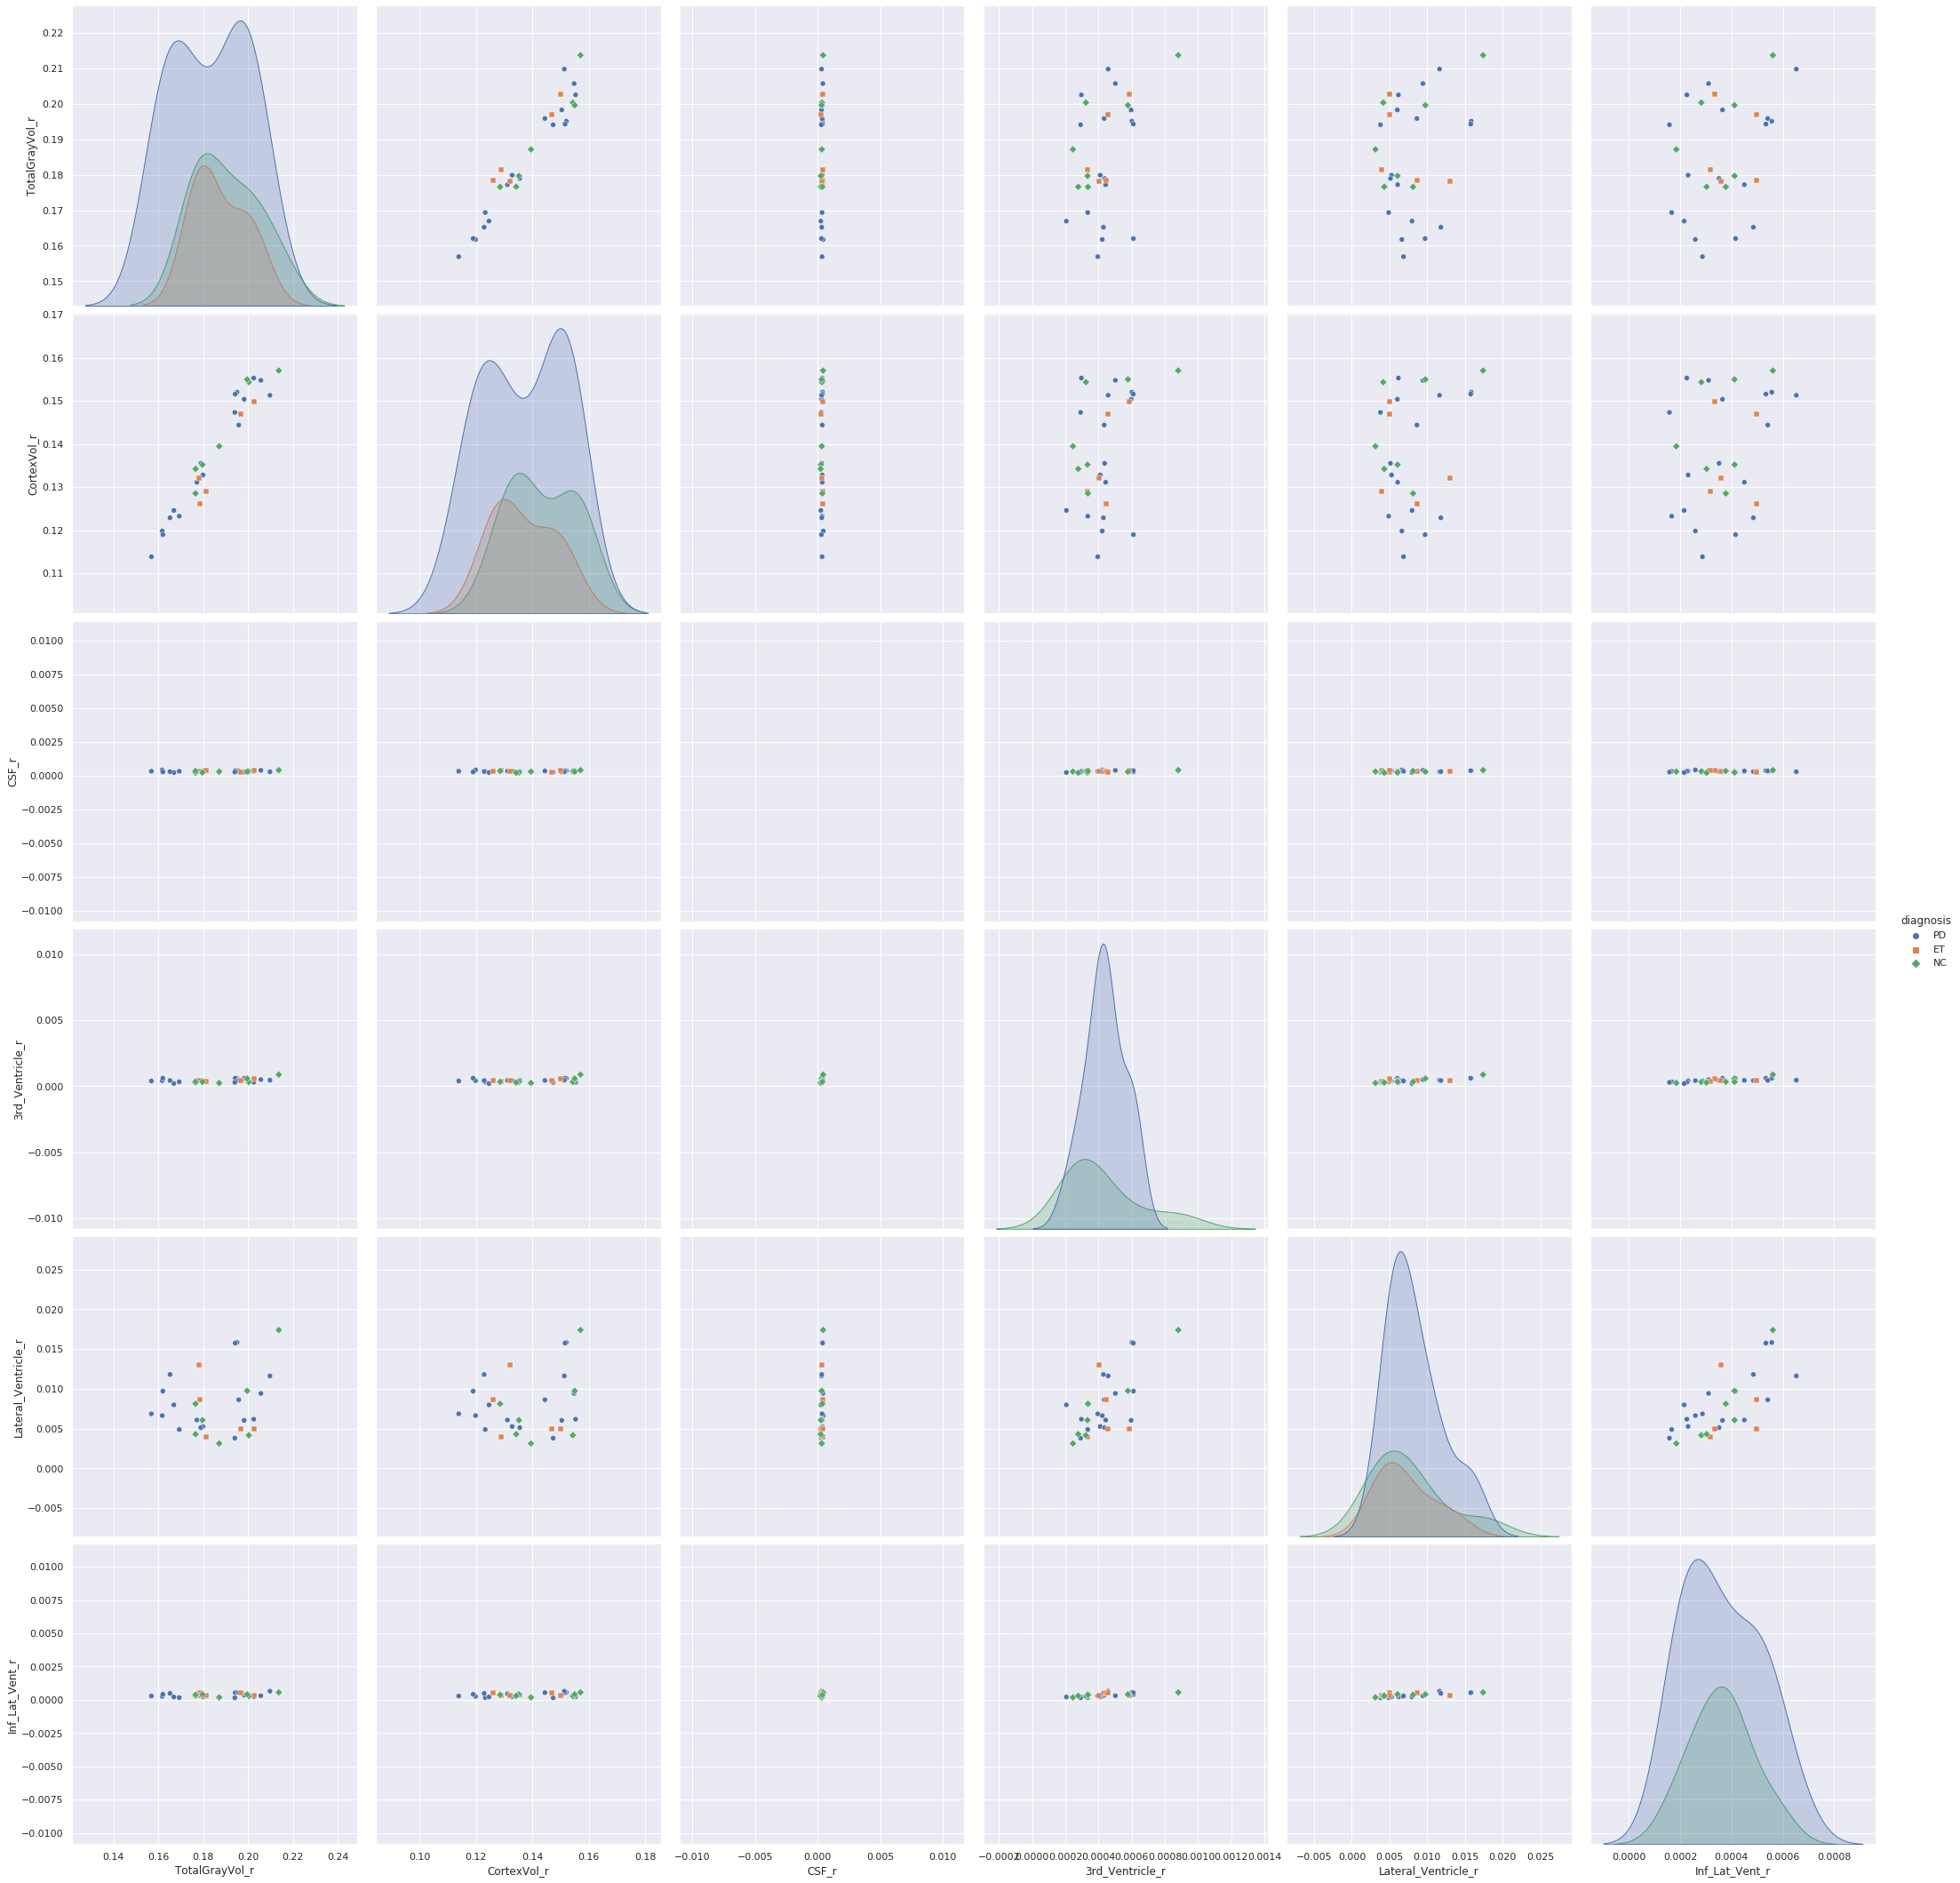

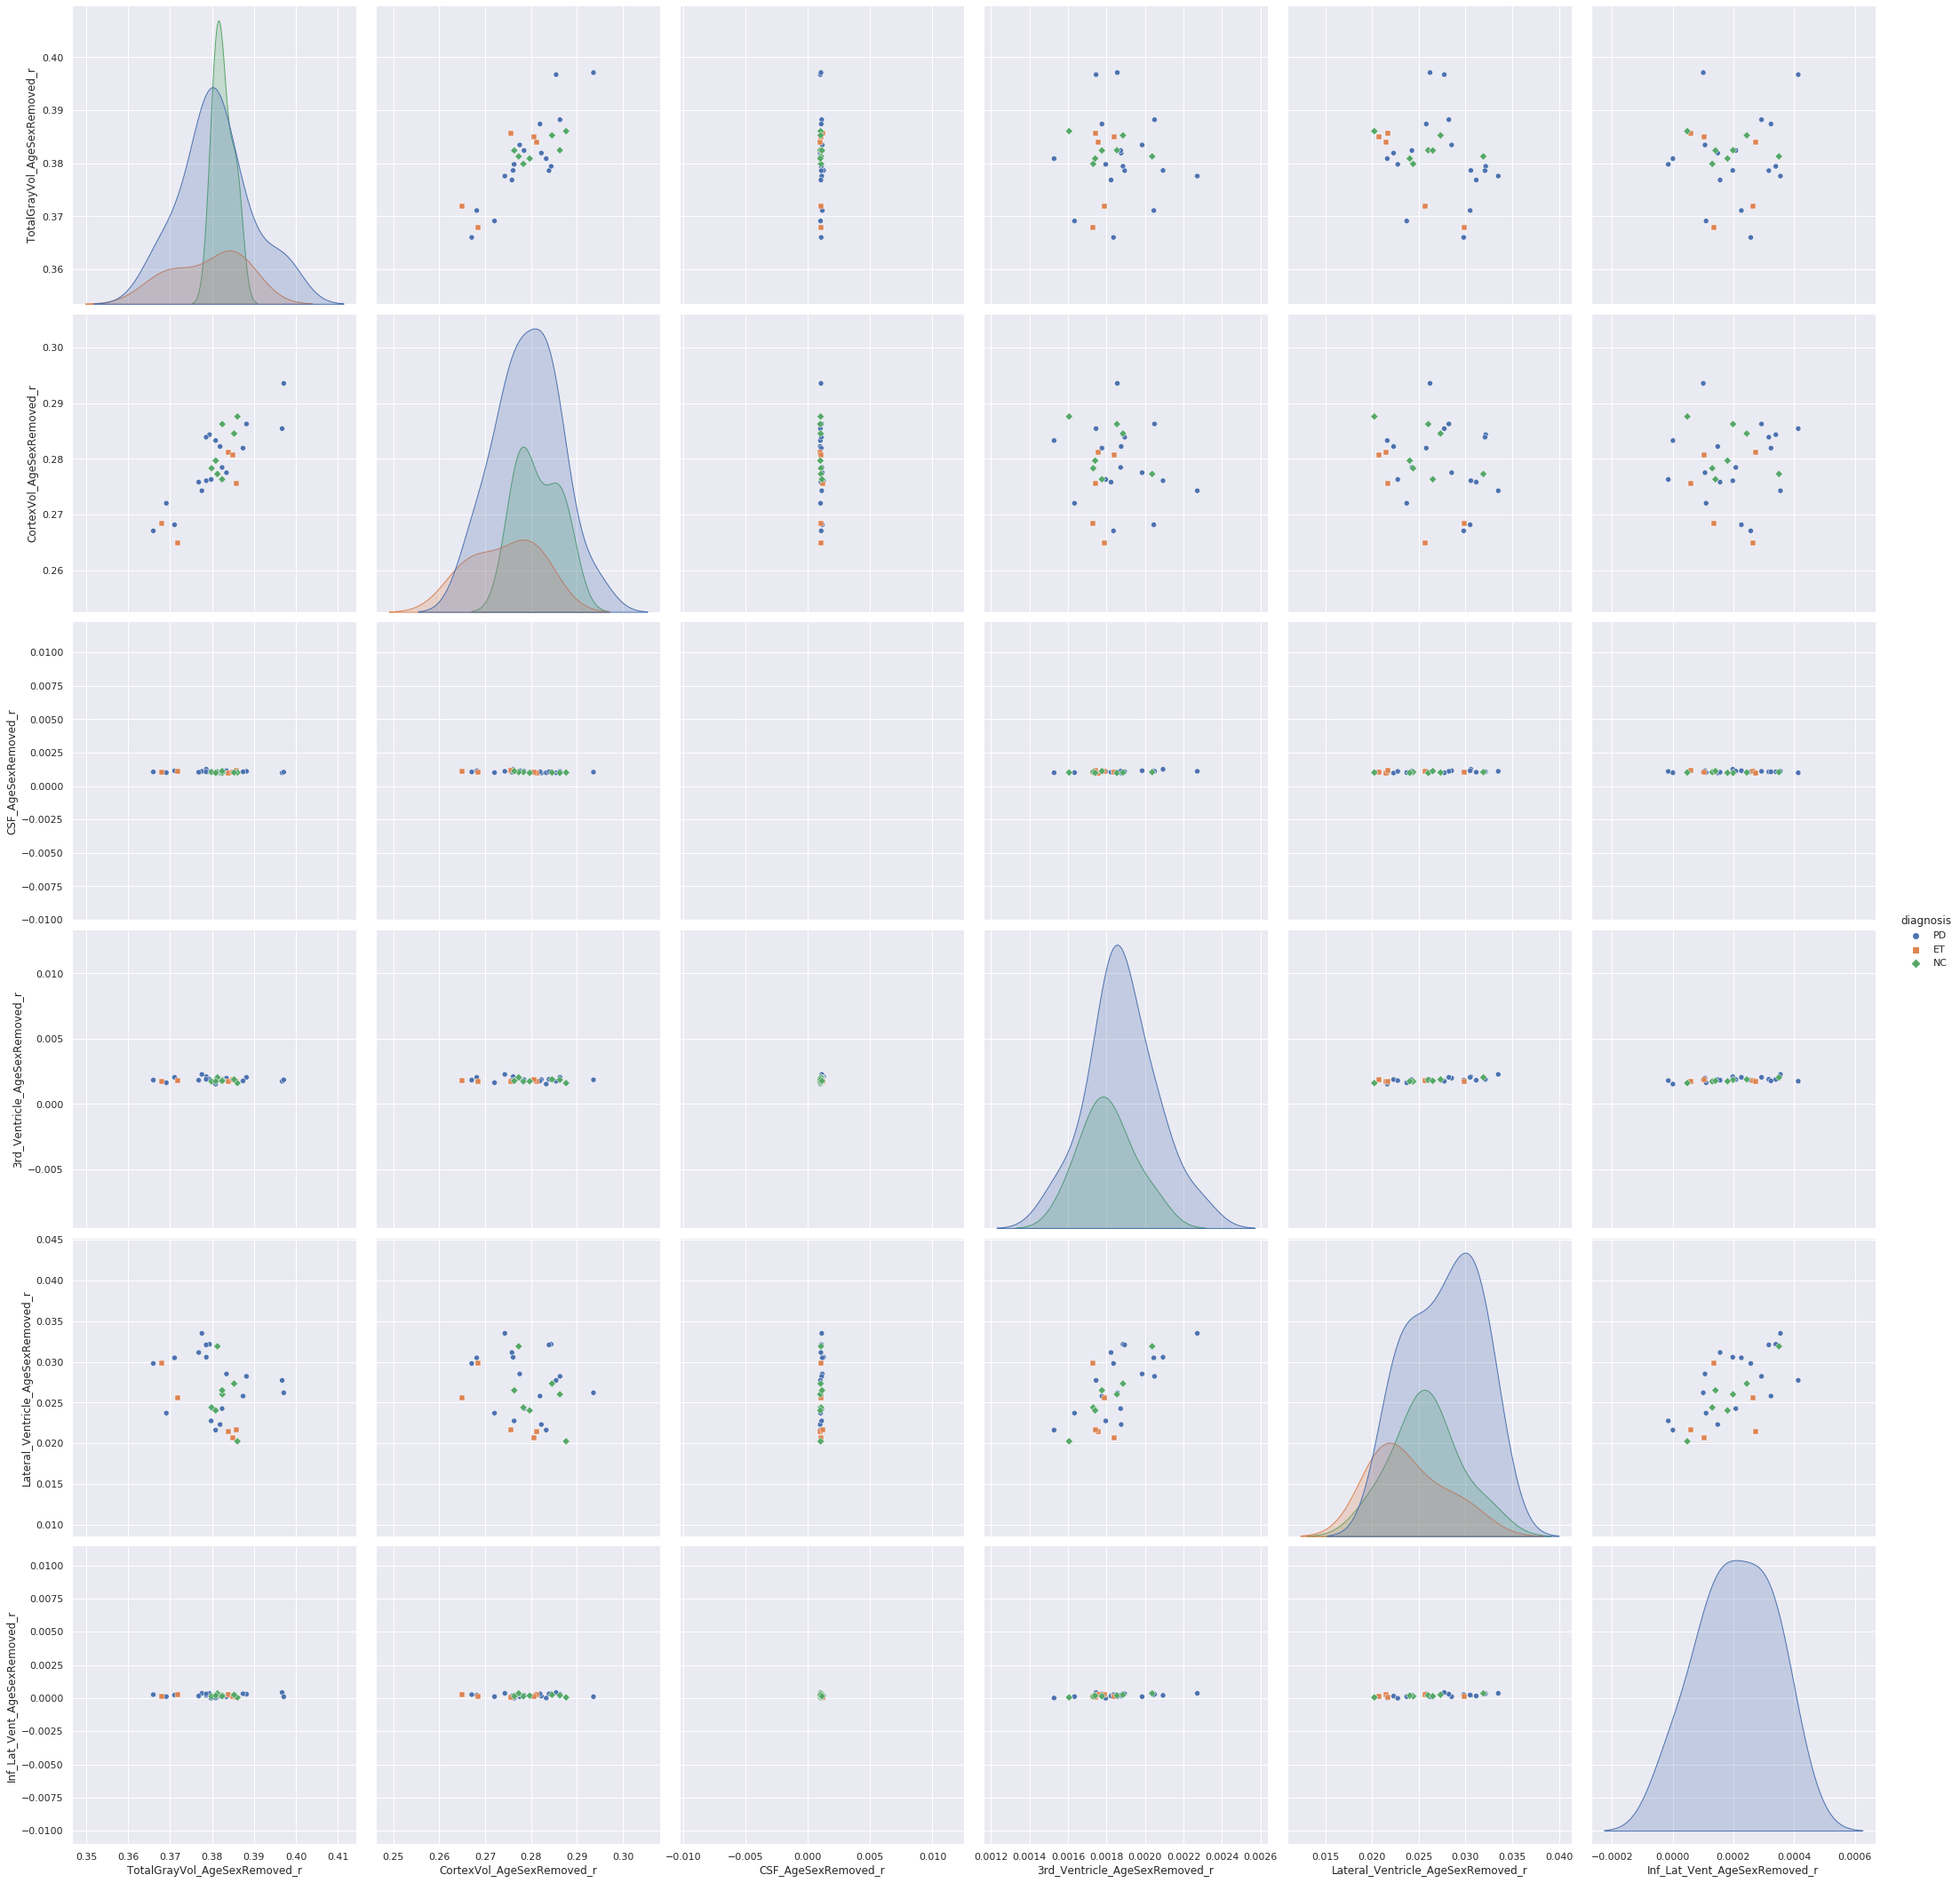

In [18]:
# all_asr_data, stf_asr_data, all_data, stf_data
region_focus = ['TotalGrayVol', 'CortexVol', 'CSF', '3rd_Ventricle', 'Lateral_Ventricle', 'Inf_Lat_Vent'];
region_r_focus = [ x+'_r'for x in region_focus];
region_asr_focus = [ x+'_AgeSexRemoved_r'for x in region_focus];

t1=sns.pairplot(stf_asr_data, vars=region_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)

t2=sns.pairplot(stf_asr_data, vars=region_r_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)

t3=sns.pairplot(stf_asr_data, vars=region_asr_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)

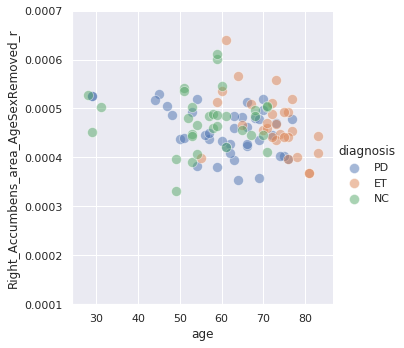

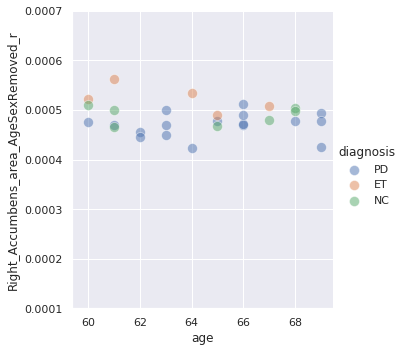

In [67]:
# all_asr_data, stf_asr_data, all_data, stf_data
region_focus = ['TotalGrayVol', 'Right_Accumbens_area'];
region_r_focus = [ x+'_r'for x in region_focus];
region_asr_focus = [ x+'_AgeSexRemoved_r'for x in region_focus];
 
#t1=sns.pairplot(all_asr_data, vars=region_asr_focus,  hue="diagnosis", markers=["o", "s", "D"],
#                diag_kind="kde", height=5)
#t1.map_lower(sns.kdeplot, levels=4, color=".2")
g = sns.FacetGrid(all_asr_data, hue="diagnosis",  height=5)
g.map(sns.scatterplot, "age", "Right_Accumbens_area_AgeSexRemoved_r", s=100, alpha=.5)
g.add_legend()
g.set(ylim=(.0001, .0007))

g = sns.FacetGrid(stf_asr_data, hue="diagnosis",  height=5)
g.map(sns.scatterplot, "age", "Right_Accumbens_area_AgeSexRemoved_r", s=100, alpha=.5)
g.add_legend()
g.set(ylim=(.0001, .0007))
#g = sns.pairplot(all_asr_data, vars=region_asr_focus, hue="diagnosis", height=5)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.scatterplot)
#g.set(ylim=(0, .0007))
#g.add_legend()

/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


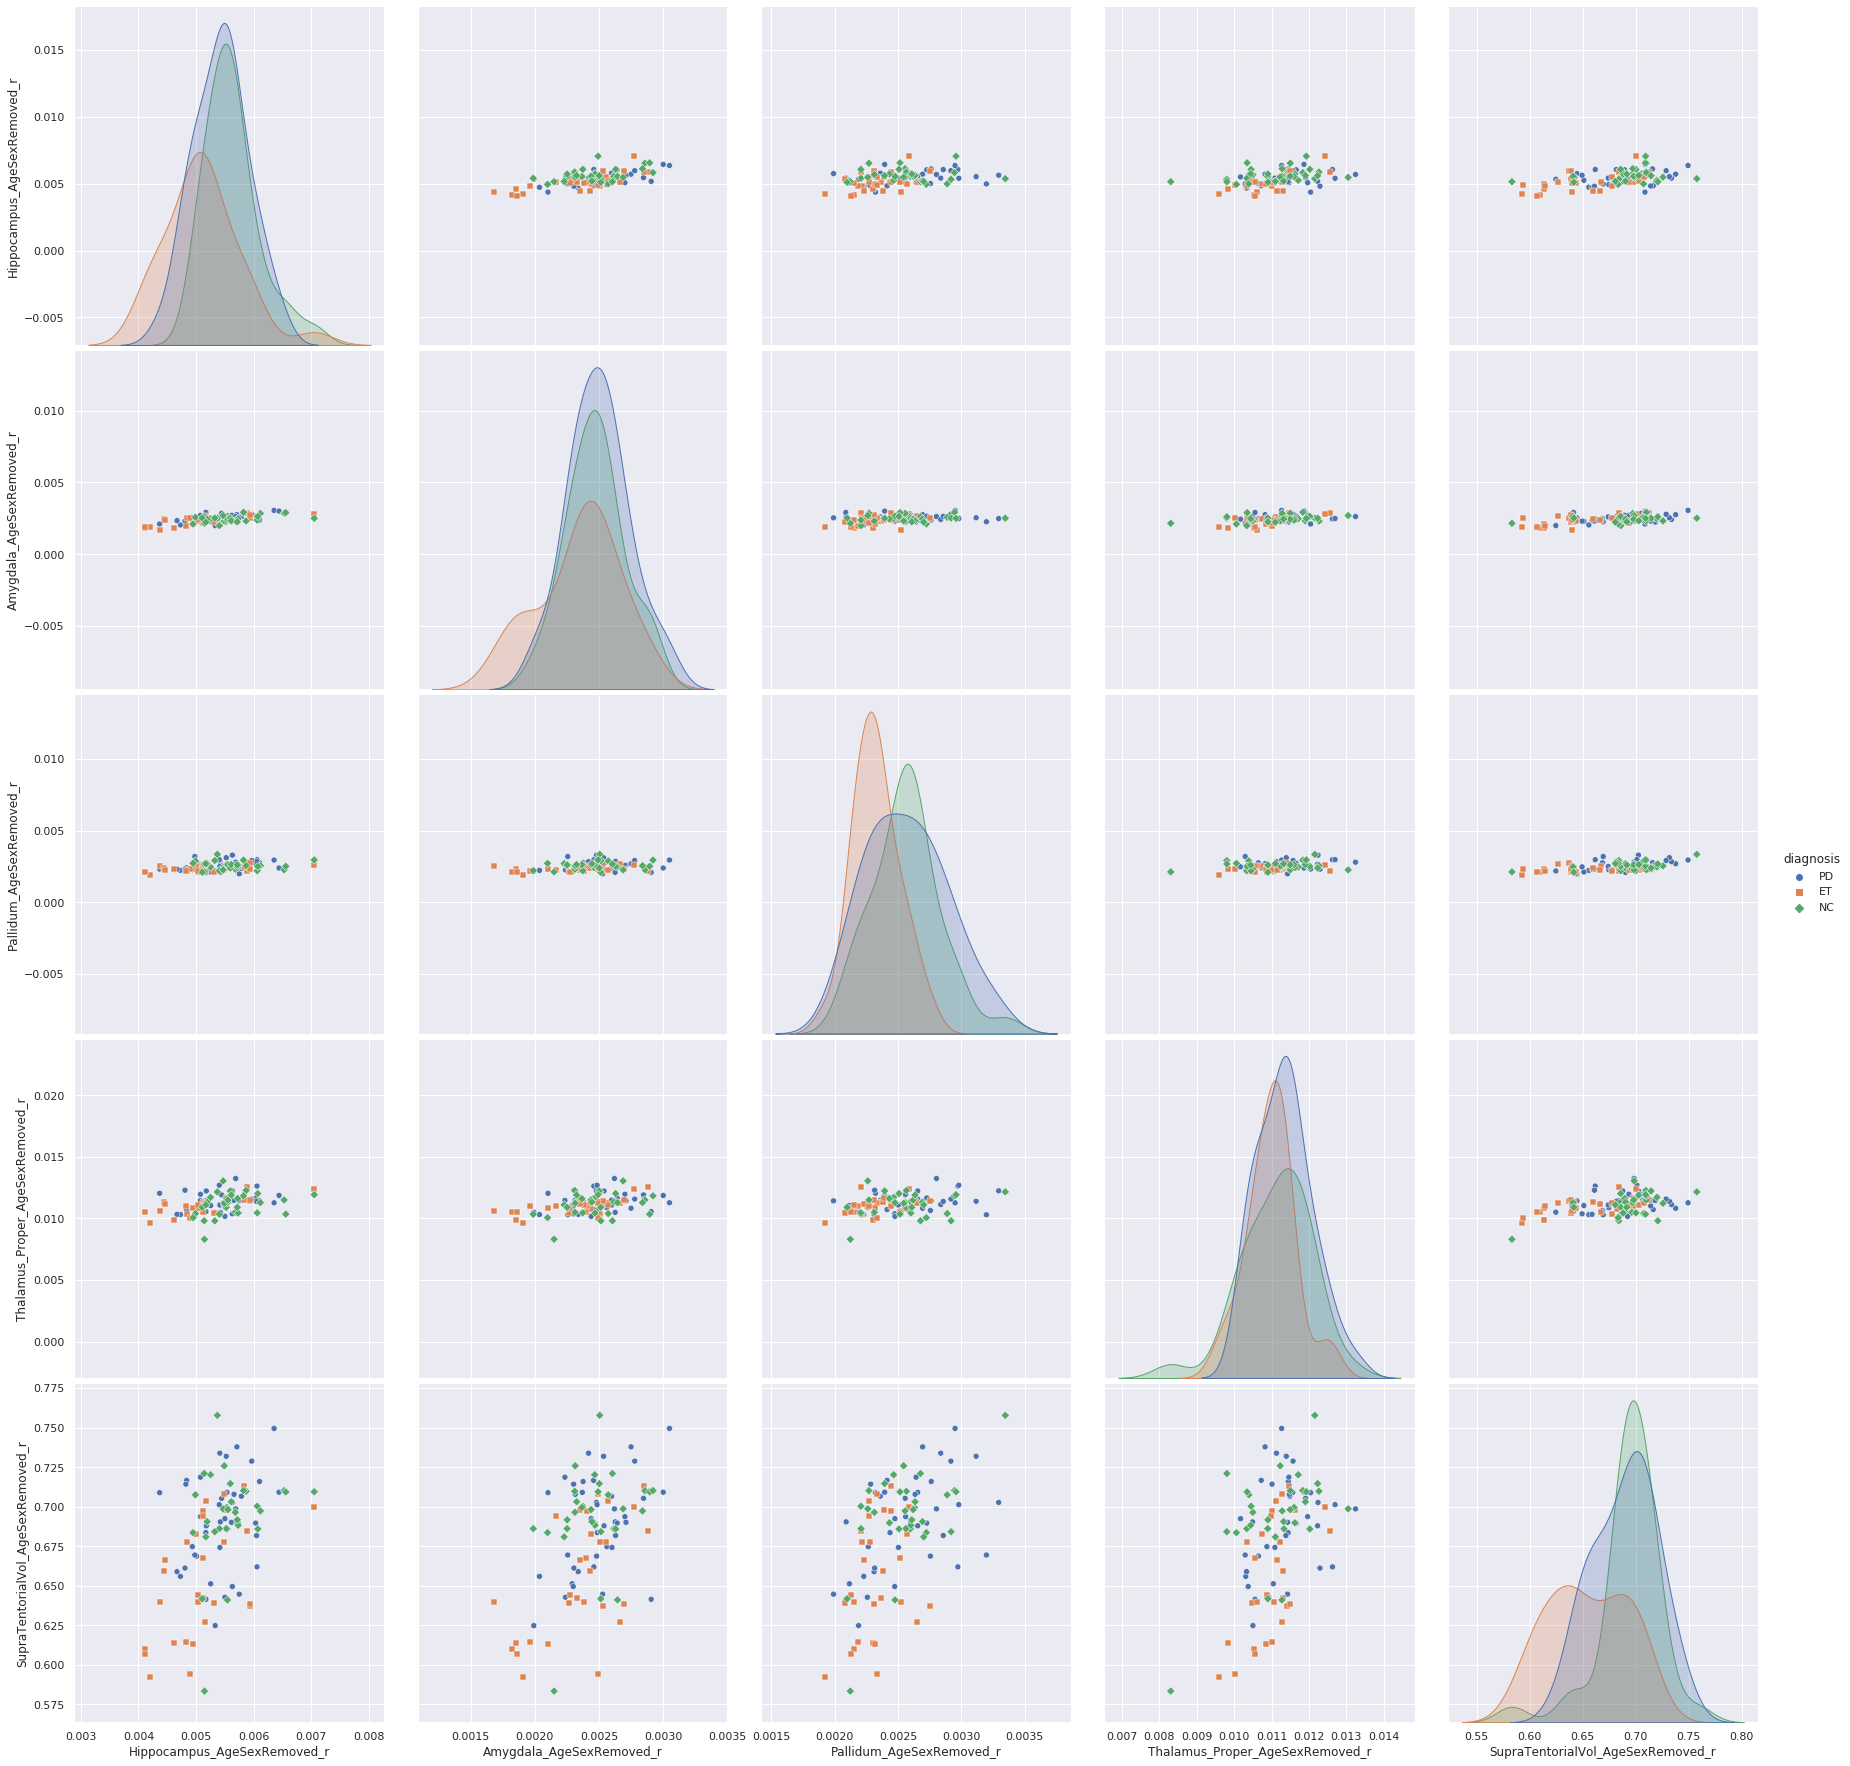

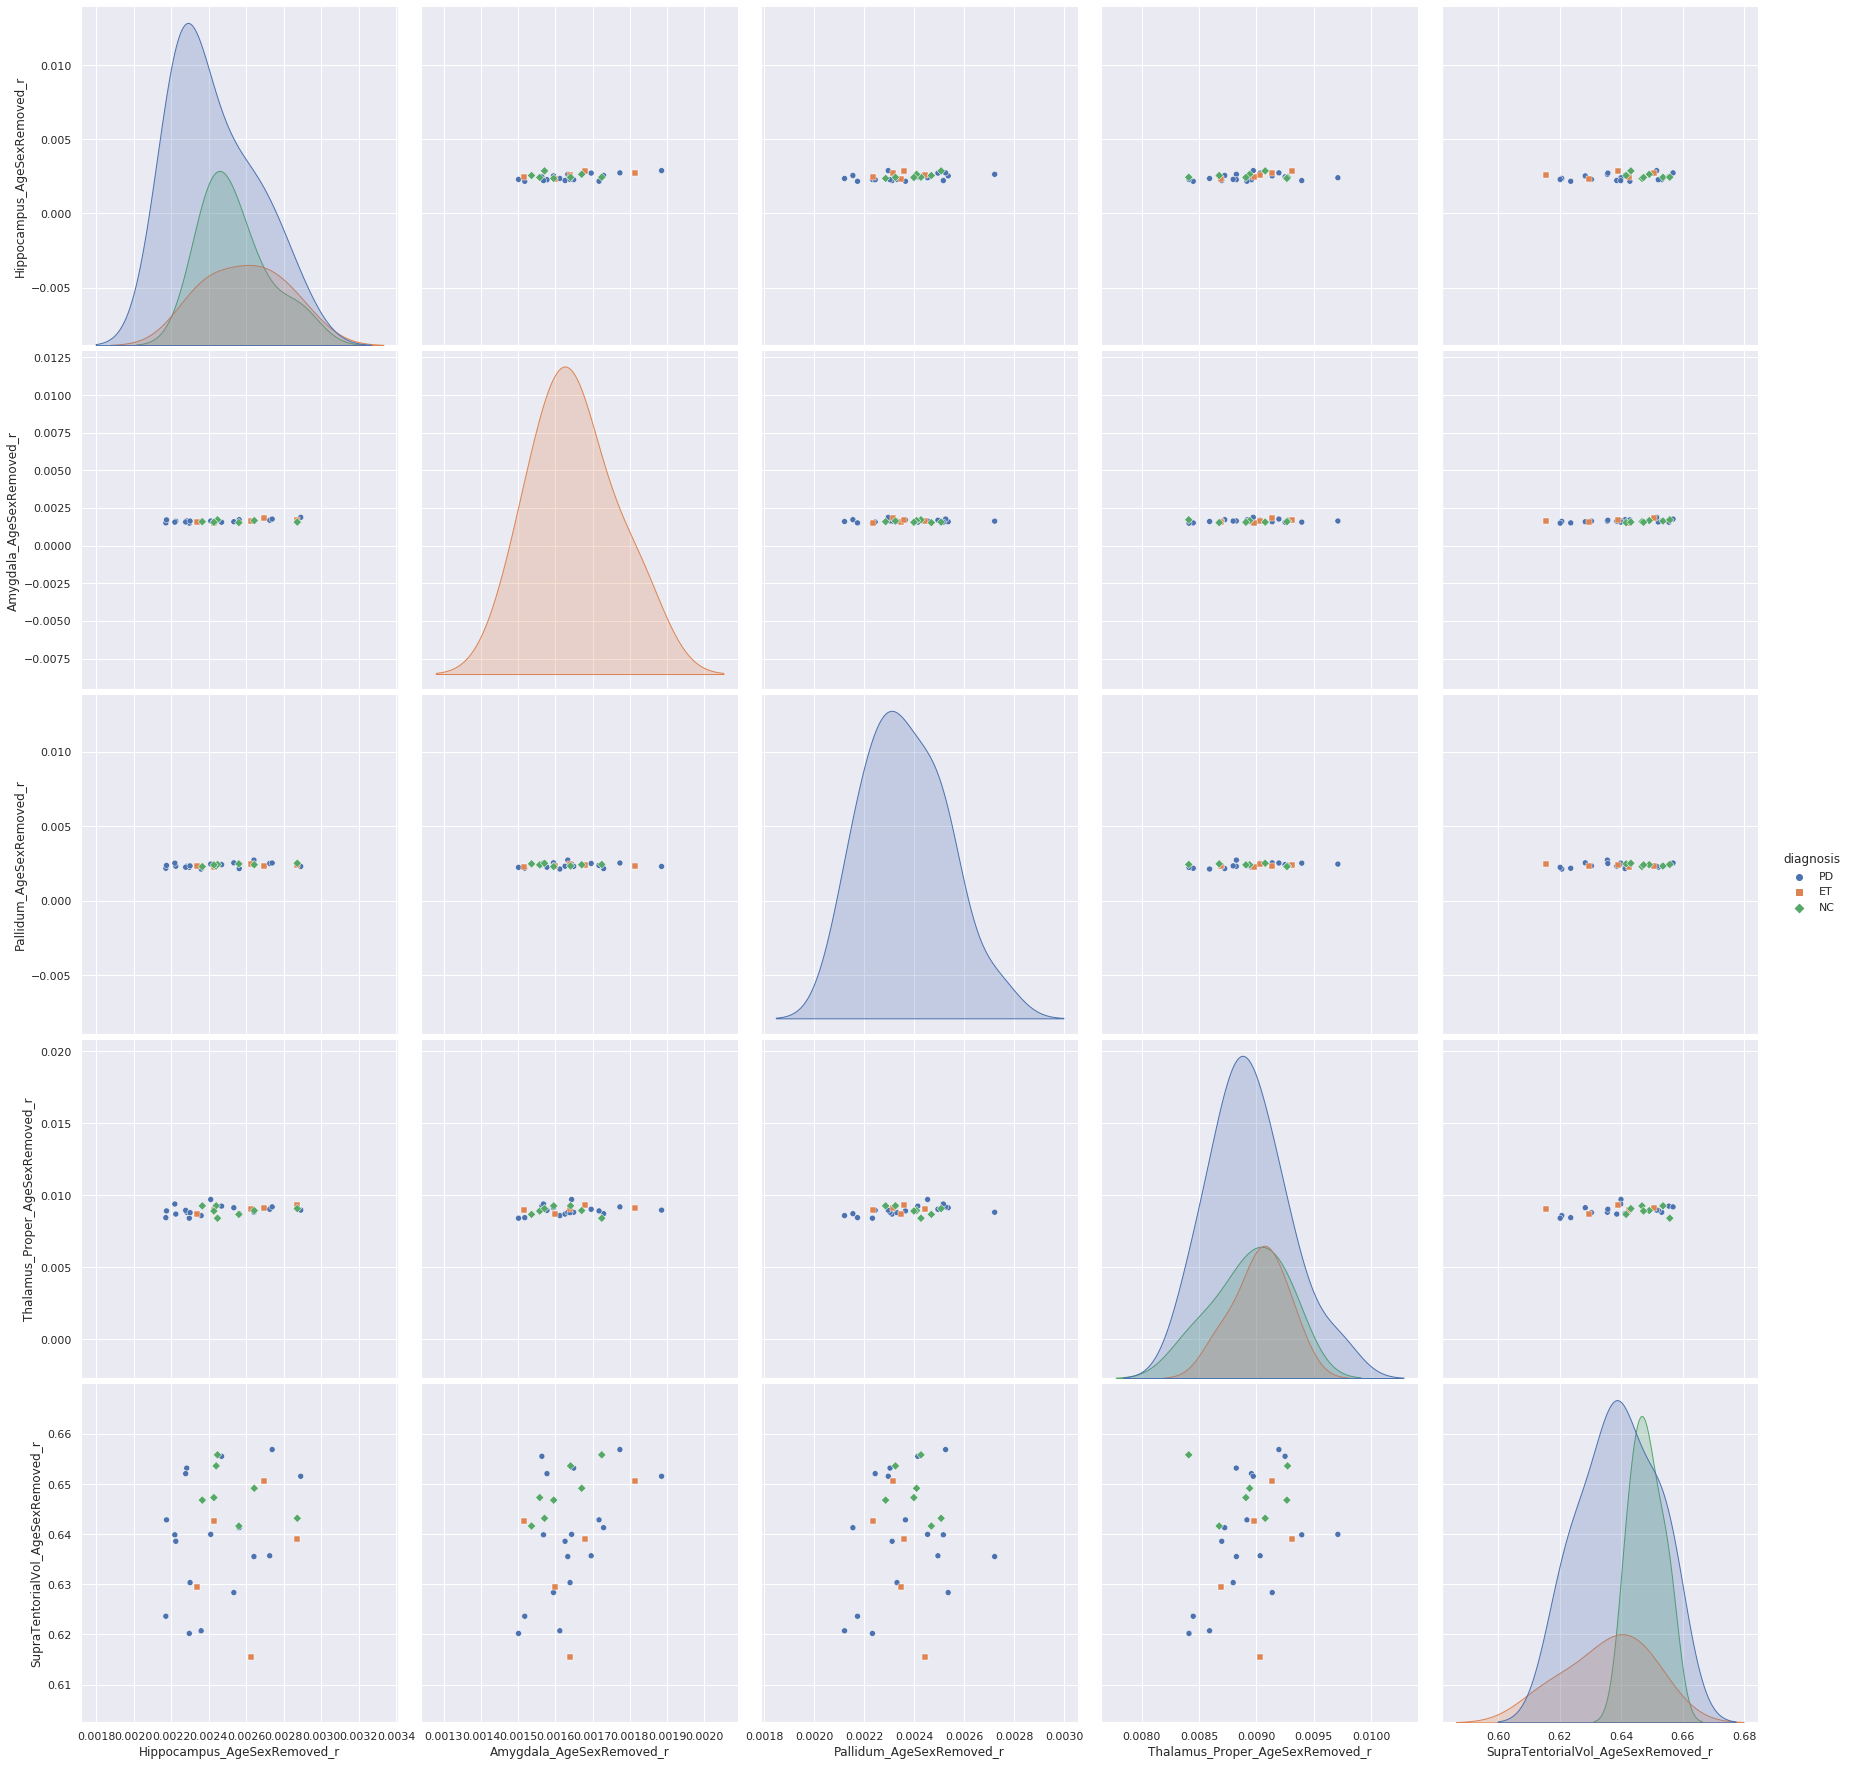

In [23]:
# all_asr_data, stf_asr_data, all_data, stf_data
region_focus = ['Hippocampus_AgeSexRemoved_r', 'Amygdala_AgeSexRemoved_r', 
                'Pallidum_AgeSexRemoved_r', 'Thalamus_Proper_AgeSexRemoved_r','SupraTentorialVol_AgeSexRemoved_r'];
t1=sns.pairplot(all_asr_data, vars=region_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)
t2=sns.pairplot(stf_asr_data, vars=region_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)

/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


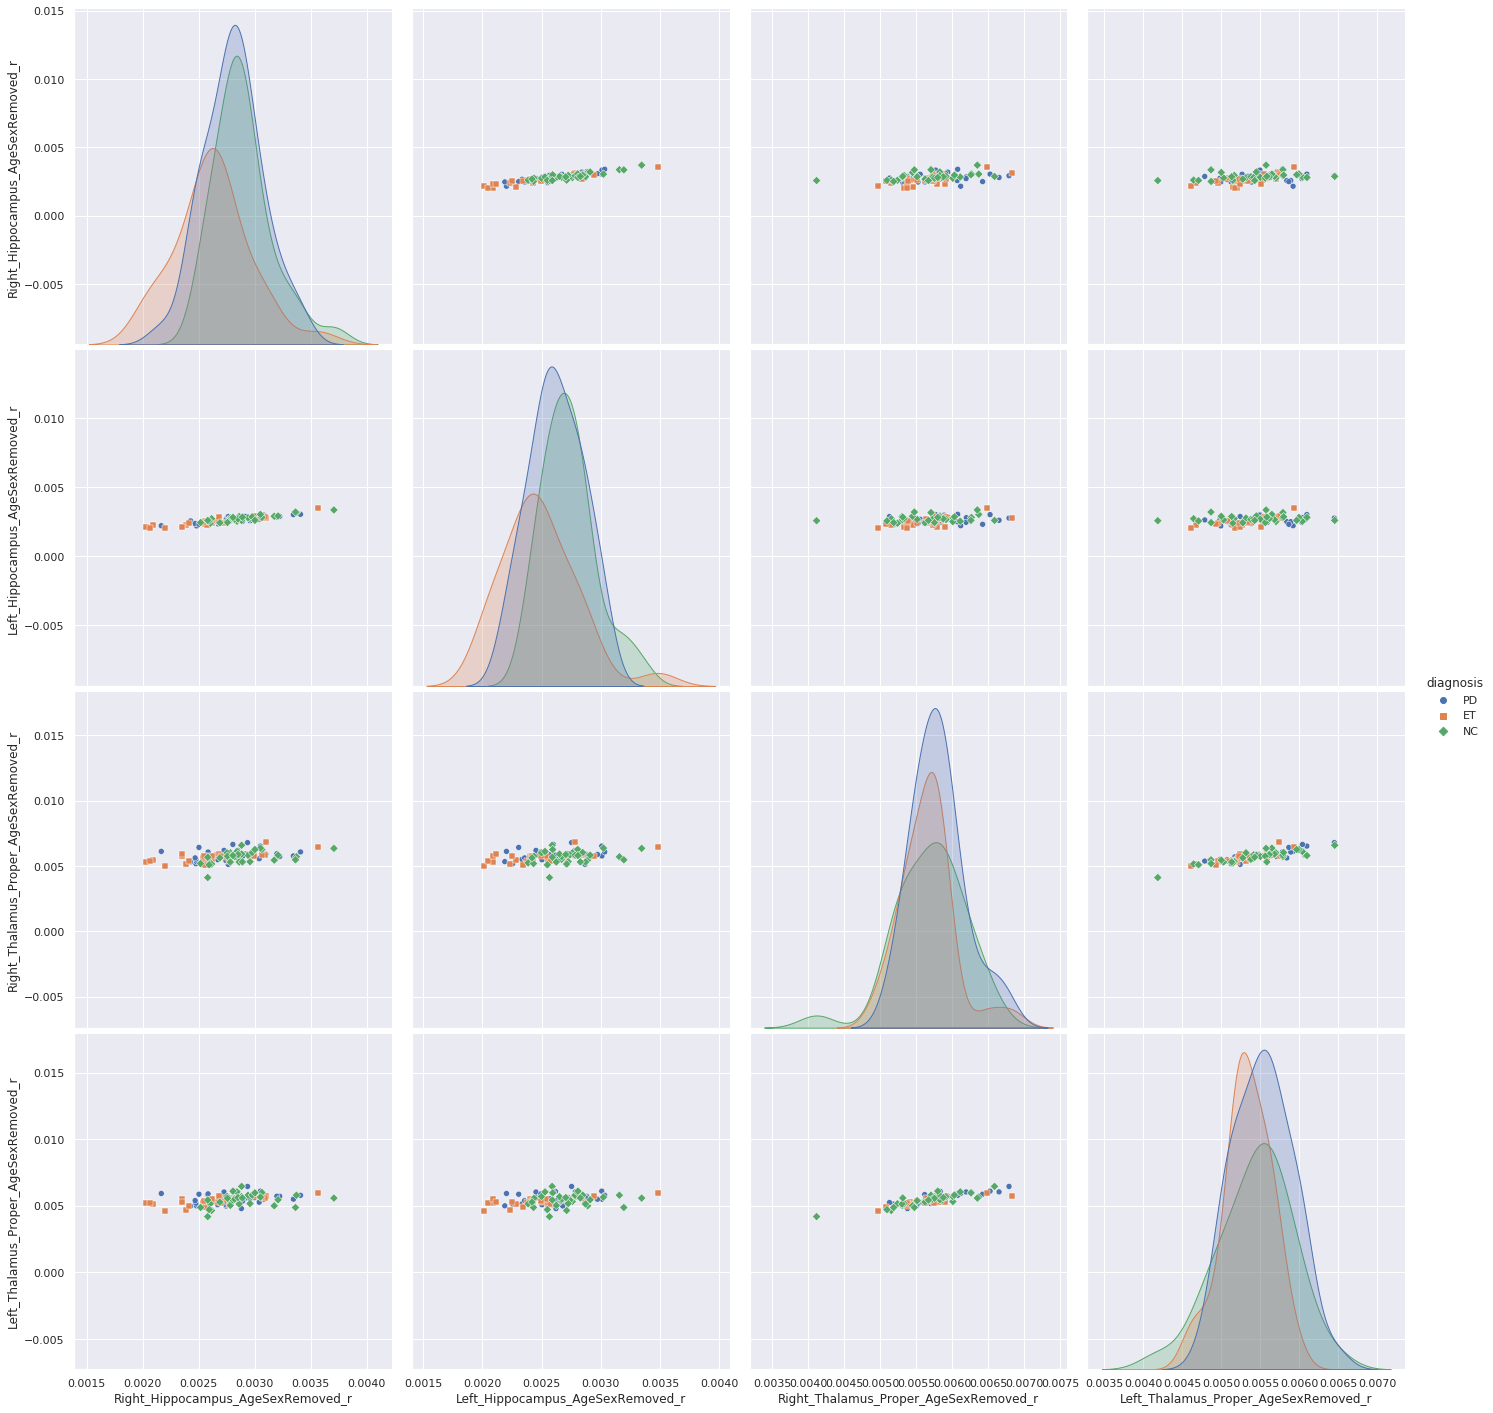

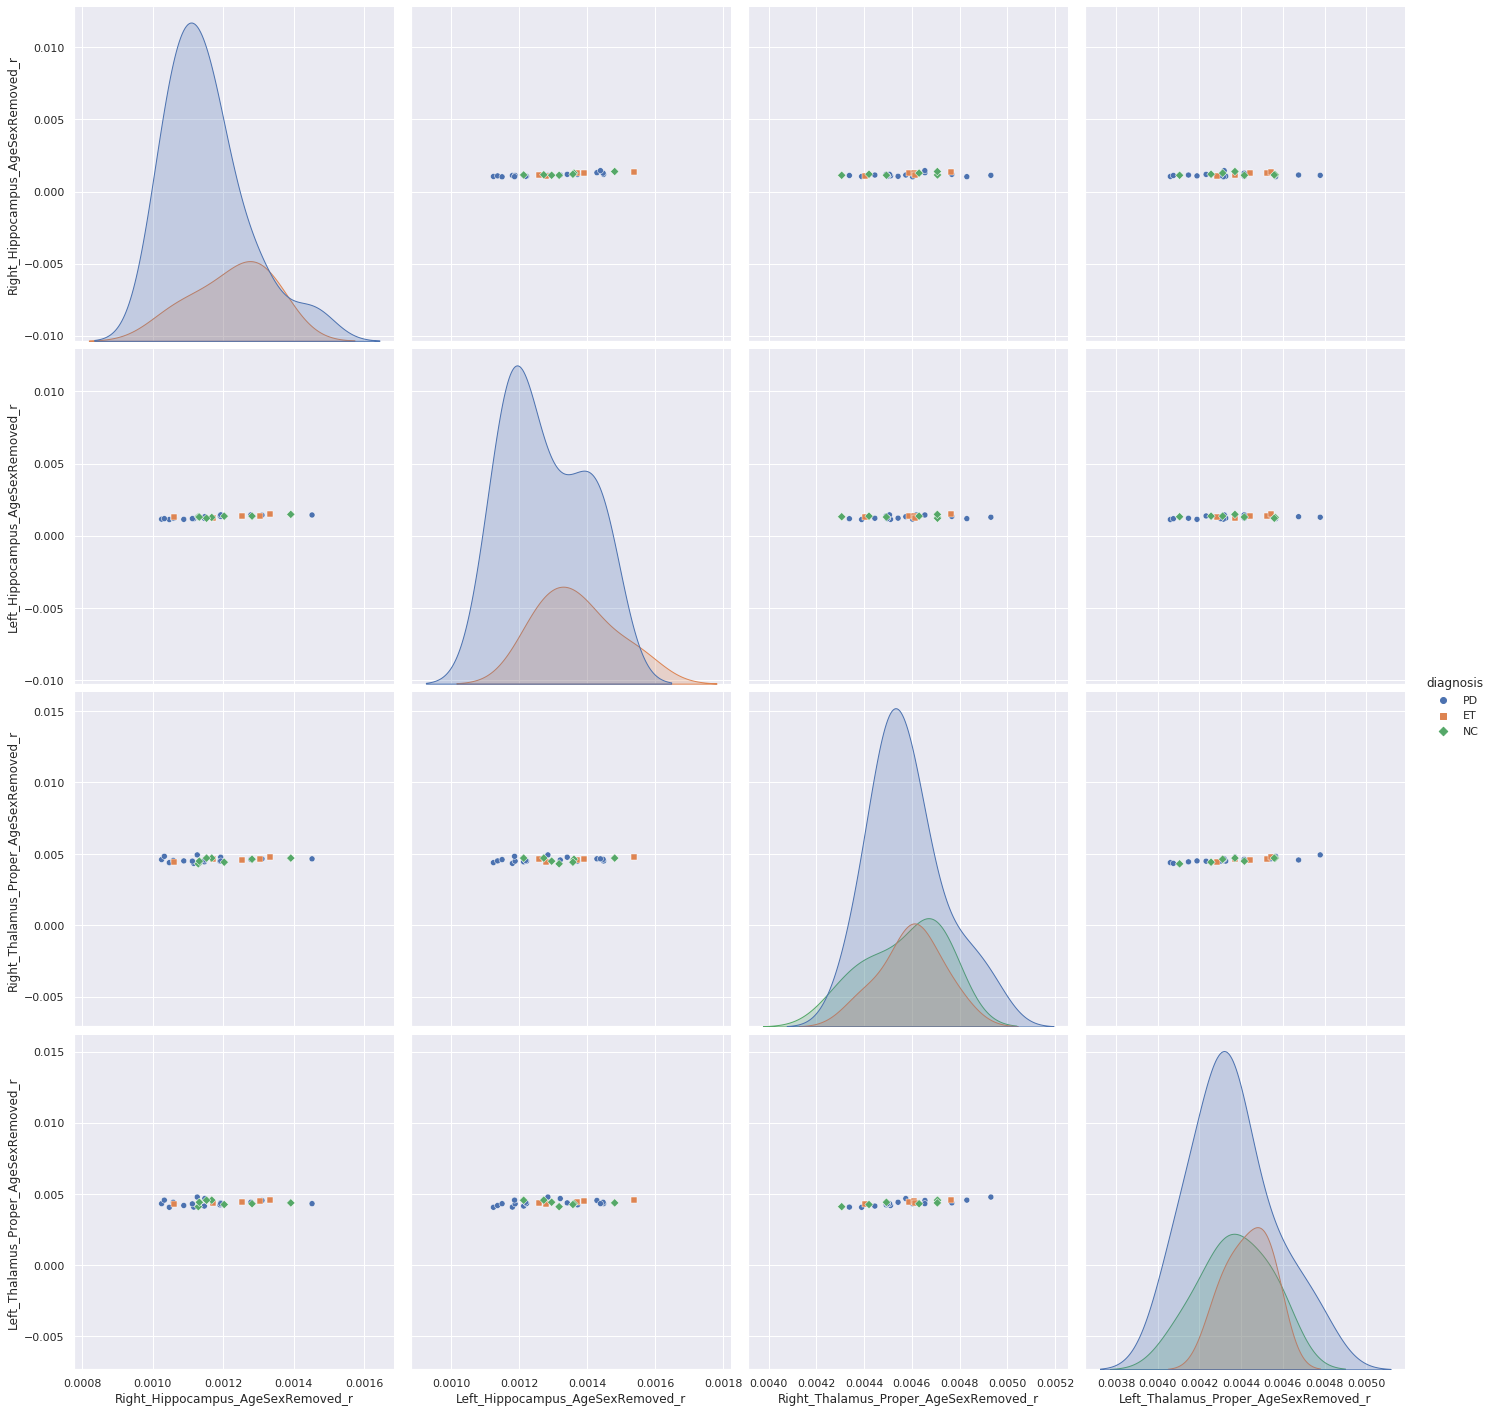

In [24]:
# all_asr_data, stf_asr_data, all_data, stf_data
region_focus = ['Right_Hippocampus_AgeSexRemoved_r', 'Left_Hippocampus_AgeSexRemoved_r',
                'Right_Thalamus_Proper_AgeSexRemoved_r', 'Left_Thalamus_Proper_AgeSexRemoved_r'];
t1=sns.pairplot(all_asr_data, vars=region_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)
t2=sns.pairplot(stf_asr_data, vars=region_focus,  hue="diagnosis", markers=["o", "s", "D"],
                diag_kind="kde", height=5)